<a href="https://colab.research.google.com/github/S1rDavid9/model_training_summative/blob/main/AkachiDavidNwanze_CodeSensAI_LearningStyle_Prediction_Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  CodeSensAI: Learning Style Prediction

**Project Overview**  

This notebook implements a complete end-to-end machine learning pipeline to predict student learning styles from behavioral and academic features. The objective is to explore how supervised machine learning and deep learning models can classify learners into one of four learning style categories:

- **0 — Visual**
- **1 — Auditory**
- **2 — Reading/Writing**
- **3 — Kinesthetic**

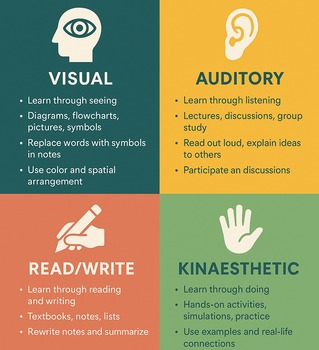


The project goes beyond simple model training. It includes:

- Data preprocessing and feature analysis  
- Traditional machine learning experiments  
- Deep learning implementation  
- Model evaluation and comparison  
- Critical interpretation of results  

This work serves both as a technical exploration of classification modeling and as a conceptual prototype for adaptive learning systems such as CodeSensAI.

---

## Problem Statement

Understanding how students learn is fundamental to delivering personalized education.

Traditional education systems often adopt a one-size-fits-all instructional approach. However, learners differ in how they process information, engage with material, and retain knowledge. If we can predict a student’s preferred learning modality, we can adjust instructional strategies accordingly.

This project focuses on predicting learning styles across four categories:

- **Visual learners** prefer diagrams, images, spatial understanding, and visual representations.
- **Auditory learners** retain information better through discussion, lectures, and spoken explanations.
- **Reading/Writing learners** engage most effectively with text-based materials.
- **Kinesthetic learners** understand concepts better through hands-on activities and experiential learning.

By accurately classifying these learning preferences using behavioral and academic features, we can simulate the foundation of a personalized learning engine.

---

##  Relevance to CodeSensAI

This project is directly aligned with the long-term vision of **CodeSensAI**, an adaptive AI-driven educational platform designed to personalize coding and STEM education — particularly for young learners.

One of the core principles behind CodeSensAI is **adaptive feedback** and **dynamic content personalization**. For such a system to function effectively, it must:

- Detect learner patterns  
- Understand engagement behavior  
- Classify learning tendencies  
- Adjust instructional strategies in real time  

The learning style prediction model developed in this notebook represents an early-stage prototype of that adaptive intelligence layer.

In a full CodeSensAI implementation, predictions like these could inform:

- How lessons are presented (video-heavy vs text-based vs interactive simulations)  
- The type of feedback provided (conceptual explanation vs example-driven guidance)  
- Pacing adjustments  
- Reinforcement strategies  
- Intervention triggers for disengagement  

This project therefore acts as a **proof of concept** for personalization mechanisms within adaptive educational systems.


**Dataset**  
- File: `student_performance.csv`
- Shape: (14003, 17)
- Target: `LearningStyle` (4 balanced classes)
- All features are integer-encoded, no missing values

**Pipeline Summary**
1. Imports & Setup
2. Data Loading & EDA
3. Preprocessing
4. Traditional ML — 9 Experiments (RF, SVM, LR × 3 each)
5. Deep Learning — 5+ Experiments
6. Final Analysis & Comparison

## 1.  Imports & Setup

I imported all necessary libraries upfront for clarity and reproducibility:

- **pandas / numpy**: Data manipulation and numerical operations
- **matplotlib / seaborn**: Visualization
- **scikit-learn**: Traditional ML models, preprocessing, evaluation
- **tensorflow / keras**: Deep learning model construction and training
- **joblib**: Model persistence (saving trained models to disk)
- **warnings**: Suppress non-critical warnings for clean output

I set a global `RANDOM_STATE = 42` seed across all libraries to ensure **full reproducibility** — the same results will appear every time the notebook is run.

In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import joblib

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams.update({'figure.dpi': 120, 'figure.figsize': (10, 5)})

ml_results  = {}   # {experiment_name: {accuracy, report, params}}
dl_results  = {}   # {experiment_name: {val_acc, test_acc, history}}

os.makedirs('models', exist_ok=True)

print(f'TensorFlow version : {tf.__version__}')
print(f'Scikit-learn version: {__import__("sklearn").__version__}')
print('Setup complete. All seeds fixed to', RANDOM_STATE)

TensorFlow version : 2.19.0
Scikit-learn version: 1.6.1
Setup complete. All seeds fixed to 42


## 2.  Data Loading & Exploratory Data Analysis (EDA)

### Why EDA first?
Before any modelling, we must deeply understand the data:
- **Class balance**: Imbalanced classes would skew accuracy metrics and require special handling (e.g., SMOTE, class weights).
- **Feature distributions**: Knowing whether features are normally distributed or skewed informs scaling choices.
- **Correlations**: Highly correlated features can cause multicollinearity in Logistic Regression and reduce interpretability in tree models.
- **Data leakage check**: Any column that directly encodes the target (e.g., `LearningStyleEncoded`) must be dropped before training.

I will generate at minimum 3 visualisations:
1. Class distribution bar chart
2. Correlation heatmap
3. Feature distribution grid (histograms)

In [2]:
df = pd.read_csv('student_performance.csv')

print('=' * 55)
print('DATASET OVERVIEW')
print('=' * 55)
print(f'Shape            : {df.shape}')
print(f'Total Cells      : {df.size:,}')
print(f'Missing Values   : {df.isnull().sum().sum()}')
print(f'Duplicate Rows   : {df.duplicated().sum()}')
print()
print('Data Types:')
print(df.dtypes.value_counts())
print()
df.head()

DATASET OVERVIEW
Shape            : (14003, 16)
Total Cells      : 224,048
Missing Values   : 0
Duplicate Rows   : 1534

Data Types:
int64    16
Name: count, dtype: int64



,StudyHours,Attendance,Resources,Extracurricular,Motivation,Internet,Gender,Age,LearningStyle,OnlineCourses,Discussions,AssignmentCompletion,ExamScore,EduTech,StressLevel,FinalGrade
0,19,64,1,0,0,1,0,19,2,8,1,59,40,0,1,3
1,19,64,1,0,0,1,0,23,3,16,0,90,66,0,1,2
2,19,64,1,0,0,1,0,28,1,19,0,67,99,1,1,0
3,19,64,1,1,0,1,0,19,2,8,1,59,40,0,1,3
4,19,64,1,1,0,1,0,23,3,16,0,90,66,0,1,2


In [3]:
print('Statistical Summary:')
df.describe().T

Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
StudyHours,14003.0,19.987431,5.890637,5.0,16.0,20.0,24.0,44.0
Attendance,14003.0,80.194316,11.472181,60.0,70.0,80.0,90.0,100.0
Resources,14003.0,1.104406,0.697362,0.0,1.0,1.0,2.0,2.0
Extracurricular,14003.0,0.594158,0.491072,0.0,0.0,1.0,1.0,1.0
Motivation,14003.0,0.905806,0.695896,0.0,0.0,1.0,1.0,2.0
Internet,14003.0,0.925516,0.262566,0.0,1.0,1.0,1.0,1.0
Gender,14003.0,0.551953,0.497311,0.0,0.0,1.0,1.0,1.0
Age,14003.0,23.532172,3.514293,18.0,20.0,24.0,27.0,29.0
LearningStyle,14003.0,1.515461,1.112941,0.0,1.0,2.0,3.0,3.0
OnlineCourses,14003.0,9.891952,6.112801,0.0,5.0,10.0,15.0,20.0


In [4]:
print('Target Variable — LearningStyle:')
print(df['LearningStyle'].value_counts().sort_index())
print()
print('Class proportions:')
print((df['LearningStyle'].value_counts(normalize=True).sort_index() * 100).round(2))

Target Variable — LearningStyle:
LearningStyle
0    3376
1    3580
2    3500
3    3547
Name: count, dtype: int64

Class proportions:
LearningStyle
0    24.11
1    25.57
2    24.99
3    25.33
Name: proportion, dtype: float64


### Class Distribution

I plotted the count of each `LearningStyle` class. A balanced distribution (all classes roughly equal) is ideal — it means standard accuracy is a meaningful metric and we don't need resampling strategies.

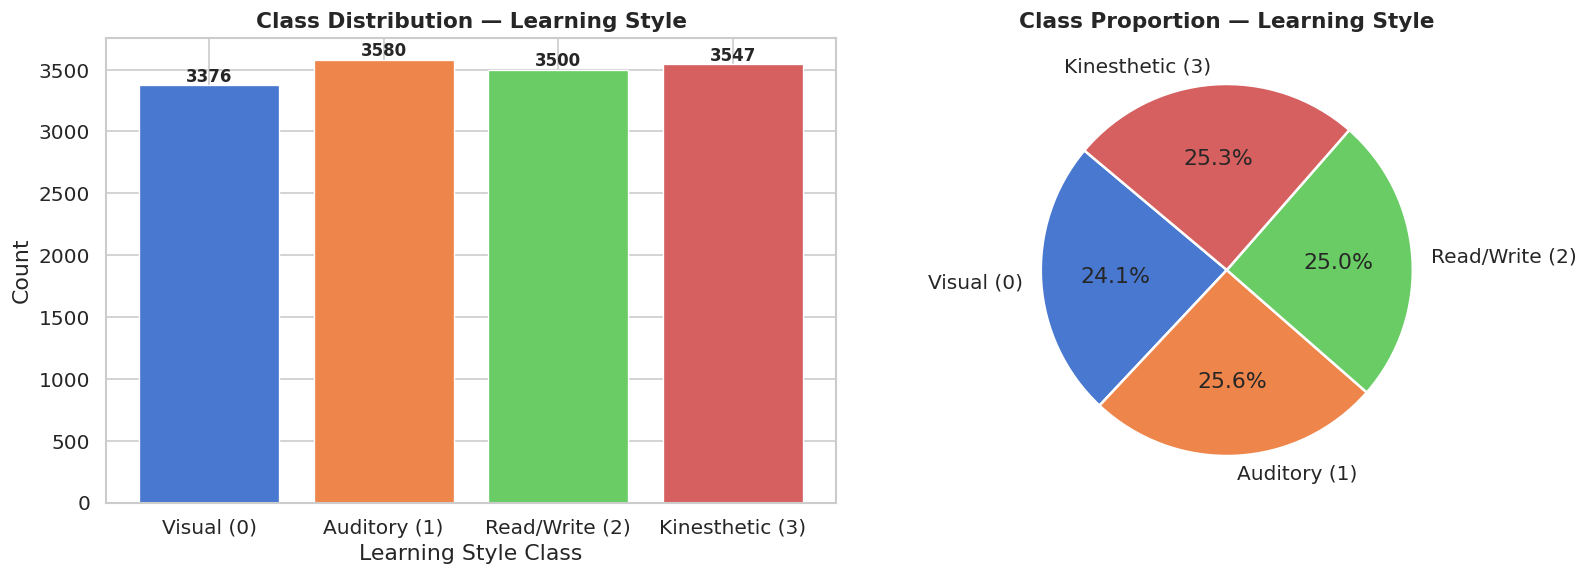

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count bar chart
class_counts = df['LearningStyle'].value_counts().sort_index()
class_labels = ['Visual (0)', 'Auditory (1)', 'Read/Write (2)', 'Kinesthetic (3)']
colors = sns.color_palette('muted', 4)

axes[0].bar(class_labels, class_counts.values, color=colors, edgecolor='white', linewidth=0.8)
axes[0].set_title('Class Distribution — Learning Style', fontweight='bold', fontsize=13)
axes[0].set_xlabel('Learning Style Class')
axes[0].set_ylabel('Count')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 30, str(v), ha='center', fontsize=10, fontweight='bold')

# Pie chart
axes[1].pie(
    class_counts.values,
    labels=class_labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)
axes[1].set_title('Class Proportion — Learning Style', fontweight='bold', fontsize=13)

plt.tight_layout()
plt.savefig('viz_class_distribution.png', bbox_inches='tight')
plt.show()

### Correlation Heatmap

The Pearson correlation heatmap reveals linear relationships between all numeric features and the target. Key things to watch:
- **High feature–feature correlation** (|r| > 0.8): Signals potential redundancy.
- **Feature–target correlation**: Hints at which features are most predictive.
- **Low correlations overall**: May indicate non-linear relationships — motivating tree-based or deep learning approaches.

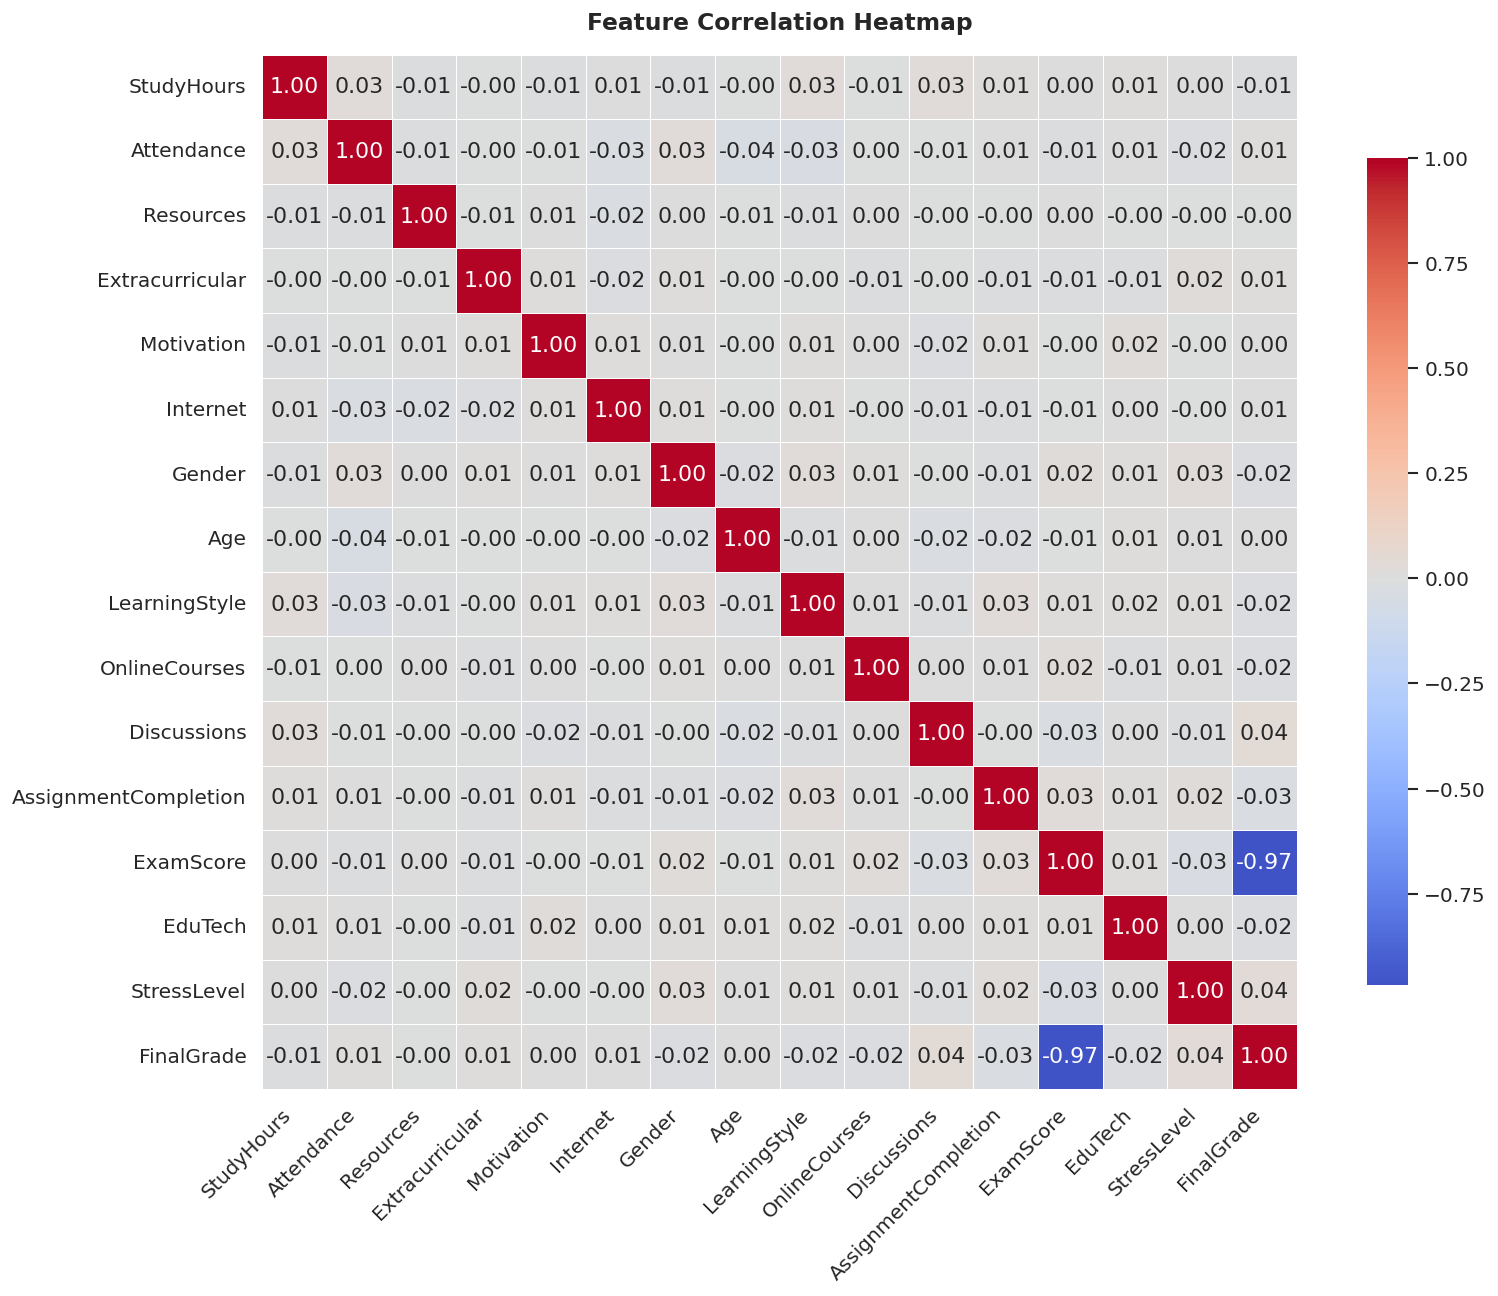

In [6]:
fig, ax = plt.subplots(figsize=(14, 11))

corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # upper triangle mask

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='white',
    square=True,
    ax=ax,
    cbar_kws={'shrink': 0.8}
)
ax.set_title('Feature Correlation Heatmap', fontweight='bold', fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('viz_correlation_heatmap.png', bbox_inches='tight')
plt.show()

### Feature Distributions by Learning Style

I plotted box plots of each feature stratified by `LearningStyle` class. This reveals whether individual features carry discriminative signal — large differences across classes suggest that feature is useful for classification.

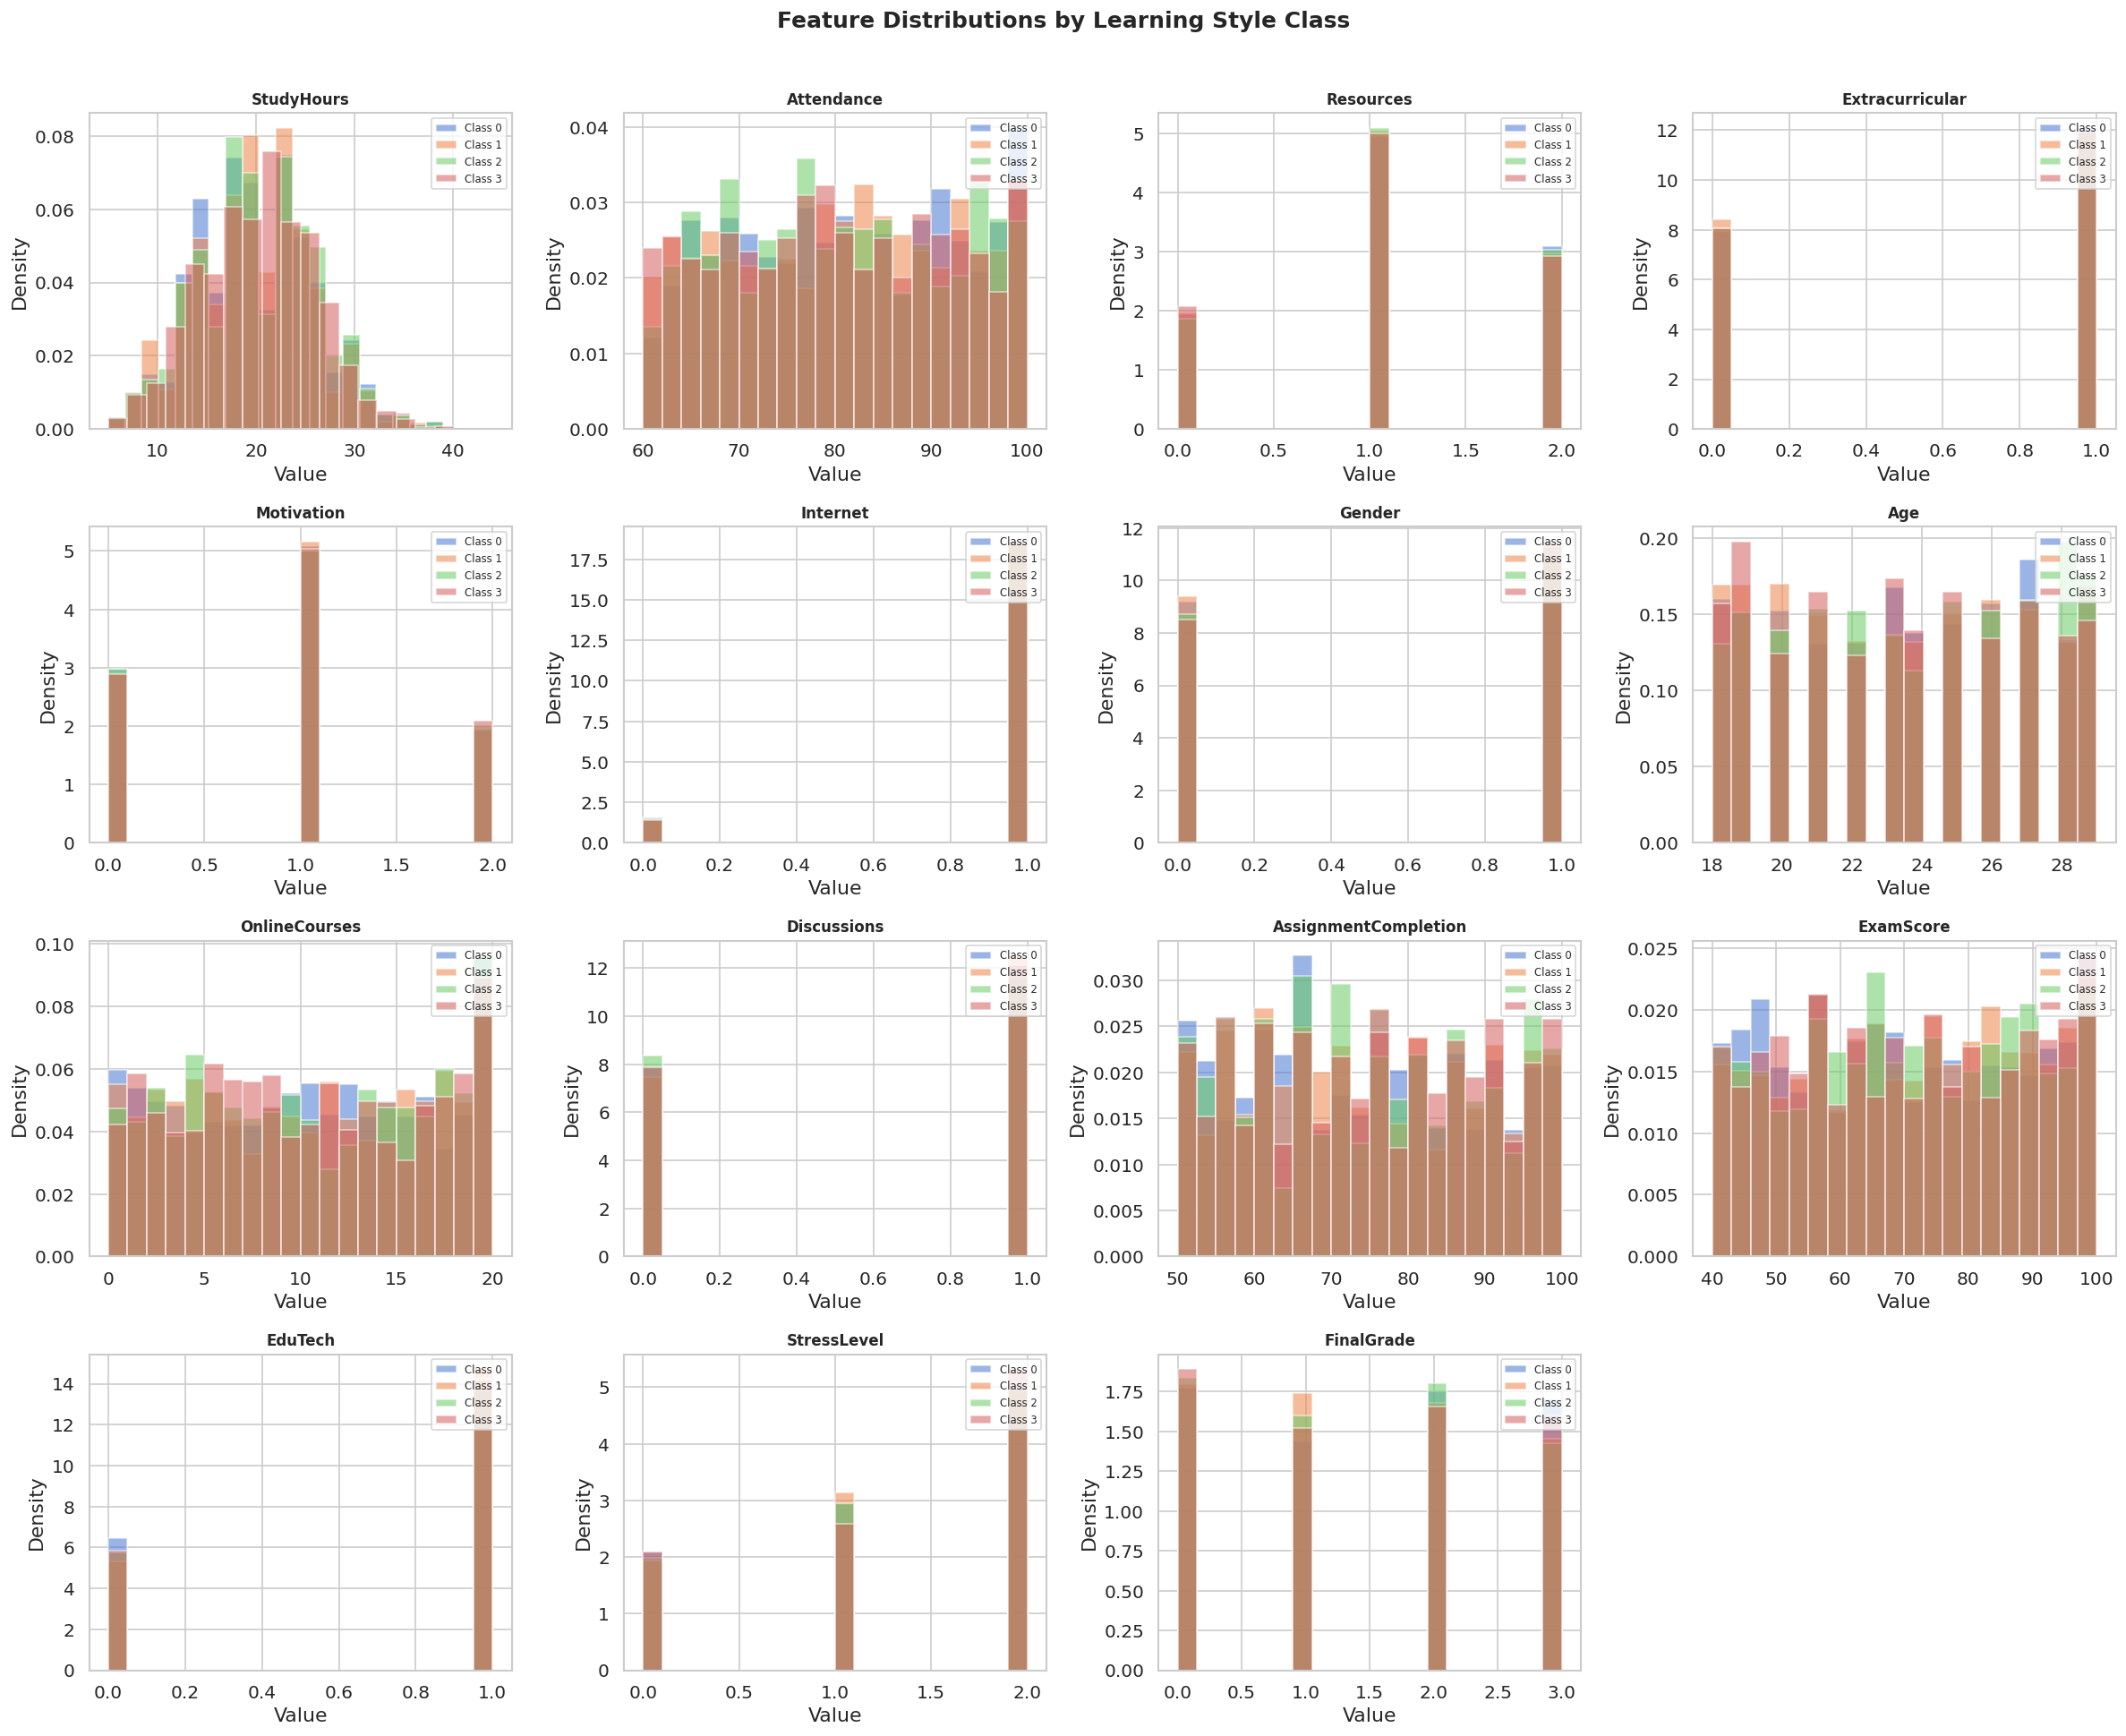

In [7]:
feature_cols = [c for c in df.columns if c != 'LearningStyle']

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    if i >= len(axes):
        break
    ax = axes[i]
    for cls, grp in df.groupby('LearningStyle'):
        ax.hist(grp[col], bins=20, alpha=0.55, label=f'Class {cls}', density=True)
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(fontsize=7, loc='upper right')

# Hide unused subplot panels
for j in range(len(feature_cols), len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Feature Distributions by Learning Style Class', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('viz_feature_distributions.png', bbox_inches='tight')
plt.show()

### Visualisation 4 — Feature Importance Preview (Mutual Information)

Mutual Information (MI) measures the non-linear statistical dependency between each feature and the target. Unlike correlation, it captures any type of relationship. High MI = high predictive power. This guides feature understanding even before training.

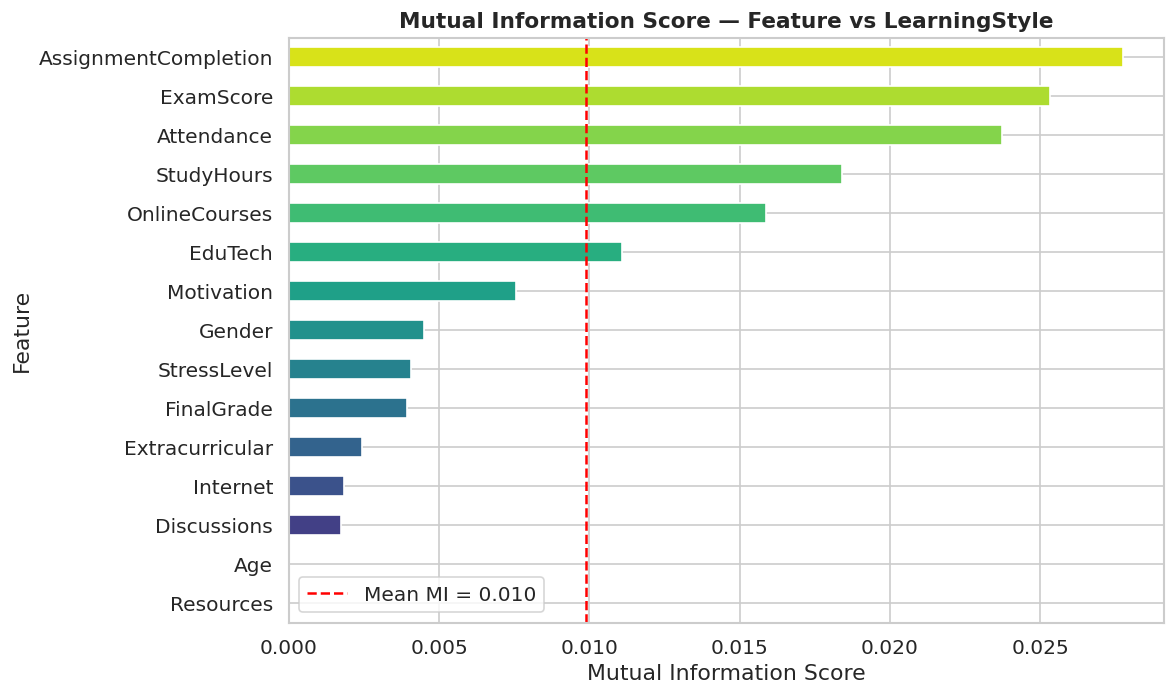

In [8]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(
    df[feature_cols], df['LearningStyle'], random_state=RANDOM_STATE
)
mi_series = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
mi_series.plot(kind='barh', ax=ax, color=sns.color_palette('viridis', len(mi_series)))
ax.set_title('Mutual Information Score — Feature vs LearningStyle', fontweight='bold', fontsize=13)
ax.set_xlabel('Mutual Information Score')
ax.set_ylabel('Feature')
ax.axvline(x=mi_series.mean(), color='red', linestyle='--', label=f'Mean MI = {mi_series.mean():.3f}')
ax.legend()
plt.tight_layout()
plt.savefig('viz_mutual_information.png', bbox_inches='tight')
plt.show()

## 3. Preprocessing

### Steps & Rationale

1. **Drop `LearningStyleEncoded`** (if present): This column would encode the target directly — using it as a feature is severe **data leakage** that inflates model accuracy and produces unreliable models.
2. **Feature/Target split**: Separate `X` (features) from `y` (target) before any splitting.
3. **Stratified train/test split (80/20)**: `stratify=y` ensures each class is proportionally represented in both train and test sets — critical for balanced multiclass problems.
4. **StandardScaler on features**: Normalises features to zero mean and unit variance. This is *essential* for:
   - SVM (kernel calculations are distance-based)
   - Logistic Regression (regularisation is scale-sensitive)
   - Neural Networks (gradient descent converges faster with normalised inputs)
   - Note: Random Forest is scale-invariant, but we scale for consistency.
5. **Scaler fit on train only**: We fit the scaler *only* on training data and apply (transform) to both train and test — fitting on test data would constitute a form of data leakage.
6. **Label validation**: Verify that the target column contains exactly 4 integer classes (0–3) and no unexpected values.

In [9]:
if 'LearningStyleEncoded' in df.columns:
    df.drop(columns=['LearningStyleEncoded'], inplace=True)
    print('Dropped LearningStyleEncoded (target leakage column)')
else:
    print('No LearningStyleEncoded column found — no leakage risk.')

unique_classes = sorted(df['LearningStyle'].unique())
assert unique_classes == [0, 1, 2, 3], f'Unexpected classes: {unique_classes}'
print(f'Target classes validated: {unique_classes}')

X = df.drop(columns=['LearningStyle'])
y = df['LearningStyle']

print(f'\nFeature matrix X: {X.shape}')
print(f'Target vector  y: {y.shape}')
print(f'Features used  : {list(X.columns)}')

No LearningStyleEncoded column found — no leakage risk.
Target classes validated: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]

Feature matrix X: (14003, 15)
Target vector  y: (14003,)
Features used  : ['StudyHours', 'Attendance', 'Resources', 'Extracurricular', 'Motivation', 'Internet', 'Gender', 'Age', 'OnlineCourses', 'Discussions', 'AssignmentCompletion', 'ExamScore', 'EduTech', 'StressLevel', 'FinalGrade']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=RANDOM_STATE,
    stratify=y       # <-- preserve class balance in both sets
)

print(f'Train set: {X_train.shape} | Test set: {X_test.shape}')
print()
print('Train class distribution:')
print(y_train.value_counts().sort_index())
print()
print('Test class distribution:')
print(y_test.value_counts().sort_index())

Train set: (11202, 15) | Test set: (2801, 15)

Train class distribution:
LearningStyle
0    2701
1    2864
2    2800
3    2837
Name: count, dtype: int64

Test class distribution:
LearningStyle
0    675
1    716
2    700
3    710
Name: count, dtype: int64


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

joblib.dump(scaler, 'models/standard_scaler.joblib')

print('StandardScaler parameters:')
print(f'  Mean (first 5 features) : {scaler.mean_[:5].round(3)}')
print(f'  Std  (first 5 features) : {scaler.scale_[:5].round(3)}')
print()
print(f'X_train_scaled shape: {X_train_scaled.shape}')
print(f'X_test_scaled  shape: {X_test_scaled.shape}')
print('Scaler saved to models/standard_scaler.joblib')

# One-hot labels for Keras (categorical_crossentropy)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test_cat  = tf.keras.utils.to_categorical(y_test,  num_classes=4)

NUM_FEATURES = X_train_scaled.shape[1]
NUM_CLASSES  = 4
print(f'\nNum features : {NUM_FEATURES}  |  Num classes: {NUM_CLASSES}')

StandardScaler parameters:
  Mean (first 5 features) : [20.003 80.227  1.107  0.596  0.909]
  Std  (first 5 features) : [ 5.869 11.45   0.697  0.491  0.694]

X_train_scaled shape: (11202, 15)
X_test_scaled  shape: (2801, 15)
Scaler saved to models/standard_scaler.joblib

Num features : 15  |  Num classes: 4


## 4. Traditional ML Experiments

I ran **3 models × 3 experiments each = 9 experiments total**.

### Helper Function
A reusable `run_ml_experiment` function trains a given sklearn estimator, evaluates it, prints a full classification report, and saves results to `ml_results` for later comparison. This follows the DRY (Don't Repeat Yourself) principle.

In [12]:
def run_ml_experiment(name, model, X_tr, y_tr, X_te, y_te, params_desc=''):
    """
    Train a scikit-learn model, evaluate on the test set, print results,
    and persist both the model and results.

    Parameters
    ----------
    name       : str   — experiment identifier (used as dict key)
    model      : sklearn estimator
    X_tr, y_tr : training data
    X_te, y_te : test data
    params_desc: str   — human-readable hyperparameter description
    """
    model.fit(X_tr, y_tr)
    preds   = model.predict(X_te)
    acc     = accuracy_score(y_te, preds)
    report  = classification_report(y_te, preds, target_names=[
        'Visual', 'Auditory', 'Read/Write', 'Kinesthetic'
    ])

    cv_scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='accuracy', n_jobs=-1)

    ml_results[name] = {
        'test_accuracy' : acc,
        'cv_mean'       : cv_scores.mean(),
        'cv_std'        : cv_scores.std(),
        'report'        : report,
        'params'        : params_desc,
        'model_type'    : type(model).__name__
    }

    # Save model to disk
    safe_name = name.replace(' ', '_').replace('/', '-')
    joblib.dump(model, f'models/ml_{safe_name}.joblib')

    # Print summary
    print(f'{'='*60}')
    print(f'EXPERIMENT: {name}')
    print(f'Params     : {params_desc}')
    print(f'Test Acc   : {acc:.4f} ({acc*100:.2f}%)')
    print(f'CV Acc     : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')
    print(f'{'='*60}')
    print(report)
    return acc

---
### 4A. Random Forest Experiments

**Why Random Forest?**  
Random Forests are ensemble methods that build multiple decision trees on random subsets of data and features, then aggregate predictions. They are:
- Robust to overfitting (via bagging)
- Naturally handle multiclass problems
- Provide feature importance scores
- Scale-invariant (don't need normalisation)

**Key hyperparameters varied:**
- `n_estimators`: Number of trees — more trees = more stable predictions but slower
- `max_depth`: Limits tree depth — controls overfitting
- `min_samples_split`: Minimum samples to split a node — higher values = smoother decision boundaries
- `max_features`: Number of features considered per split — 'sqrt' is standard for classification

#### RF Experiment 1 — Baseline (n_estimators=100, default settings)
I started with scikit-learn's defaults as a baseline. This establishes a performance floor that subsequent experiments should improve upon.

In [13]:
rf1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
run_ml_experiment(
    name='RF_Exp1_Baseline',
    model=rf1,
    X_tr=X_train_scaled, y_tr=y_train,
    X_te=X_test_scaled,  y_te=y_test,
    params_desc='n_estimators=100, max_depth=None, max_features=sqrt'
)

EXPERIMENT: RF_Exp1_Baseline
Params     : n_estimators=100, max_depth=None, max_features=sqrt
Test Acc   : 0.9090 (90.90%)
CV Acc     : 0.8944 ± 0.0063
              precision    recall  f1-score   support

      Visual       0.93      0.90      0.91       675
    Auditory       0.90      0.92      0.91       716
  Read/Write       0.90      0.92      0.91       700
 Kinesthetic       0.91      0.90      0.91       710

    accuracy                           0.91      2801
   macro avg       0.91      0.91      0.91      2801
weighted avg       0.91      0.91      0.91      2801



0.9089610853266691

#### RF Experiment 2 — More Trees + Depth Control
I increased `n_estimators` to 300 to reduce variance further, and cap `max_depth=20` to prevent fully-grown trees from memorising training noise. I also increased `min_samples_split=5` to enforce smoother splits.

In [14]:
rf2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
run_ml_experiment(
    name='RF_Exp2_DepthControl',
    model=rf2,
    X_tr=X_train_scaled, y_tr=y_train,
    X_te=X_test_scaled,  y_te=y_test,
    params_desc='n_estimators=300, max_depth=20, min_samples_split=5'
)

EXPERIMENT: RF_Exp2_DepthControl
Params     : n_estimators=300, max_depth=20, min_samples_split=5
Test Acc   : 0.9061 (90.61%)
CV Acc     : 0.8951 ± 0.0063
              precision    recall  f1-score   support

      Visual       0.94      0.90      0.92       675
    Auditory       0.89      0.91      0.90       716
  Read/Write       0.89      0.91      0.90       700
 Kinesthetic       0.91      0.91      0.91       710

    accuracy                           0.91      2801
   macro avg       0.91      0.91      0.91      2801
weighted avg       0.91      0.91      0.91      2801



0.9061049625133881

#### RF Experiment 3 — Large Forest + Aggressive Regularisation
Here I pushed `n_estimators` to 500, cap depth at 15, raise `min_samples_split=10`, and switch `max_features` to `'log2'` (log base 2 of total features) — a more aggressive randomisation that forces each tree to rely on fewer features, encouraging diversity in the ensemble.

EXPERIMENT: RF_Exp3_AggressiveReg
Params     : n_estimators=500, max_depth=15, min_samples_split=10, max_features=log2
Test Acc   : 0.8868 (88.68%)
CV Acc     : 0.8612 ± 0.0110
              precision    recall  f1-score   support

      Visual       0.92      0.87      0.90       675
    Auditory       0.86      0.89      0.88       716
  Read/Write       0.88      0.90      0.89       700
 Kinesthetic       0.89      0.88      0.89       710

    accuracy                           0.89      2801
   macro avg       0.89      0.89      0.89      2801
weighted avg       0.89      0.89      0.89      2801



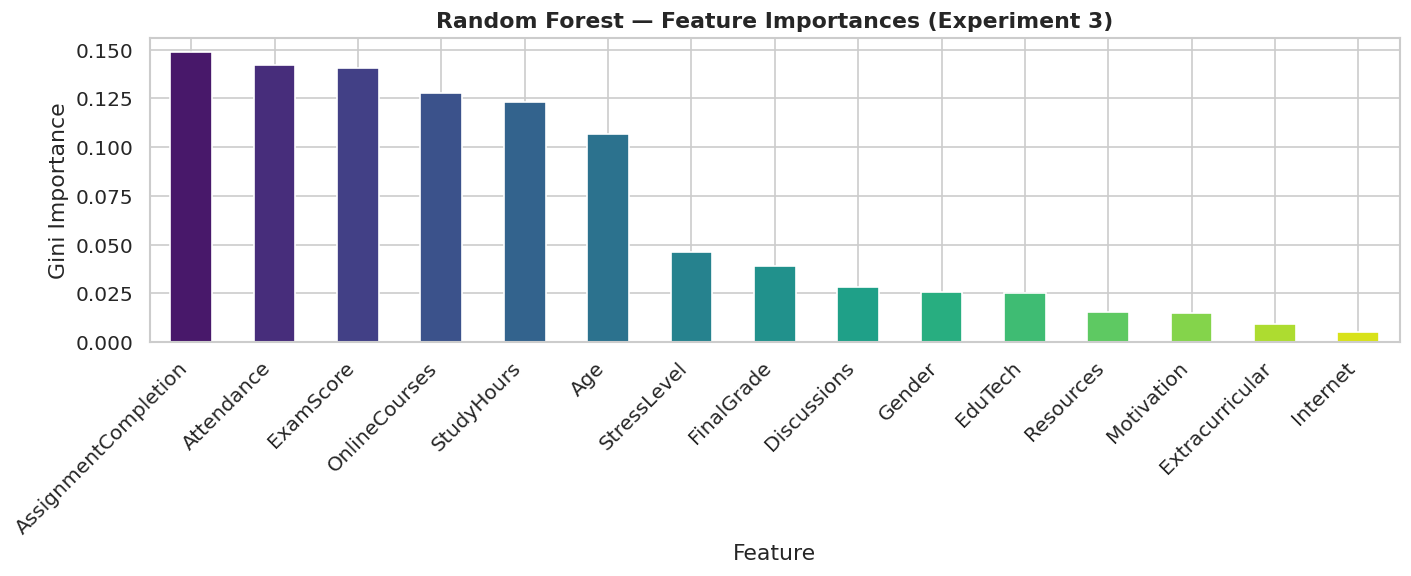

In [15]:
rf3 = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=10,
    max_features='log2',
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
run_ml_experiment(
    name='RF_Exp3_AggressiveReg',
    model=rf3,
    X_tr=X_train_scaled, y_tr=y_train,
    X_te=X_test_scaled,  y_te=y_test,
    params_desc='n_estimators=500, max_depth=15, min_samples_split=10, max_features=log2'
)

importances = pd.Series(rf3.feature_importances_, index=X.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 5))
importances.plot(kind='bar', ax=ax, color=sns.color_palette('viridis', len(importances)))
ax.set_title('Random Forest — Feature Importances (Experiment 3)', fontweight='bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Gini Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('viz_rf_feature_importance.png', bbox_inches='tight')
plt.show()

---
### 4B. Support Vector Machine (SVM) Experiments

**Why SVM?**  
SVMs find the maximum-margin hyperplane separating classes. They are effective in high-dimensional spaces and with a variety of kernel functions that project data into higher-dimensional feature spaces where linear separation becomes possible.

**Key hyperparameters varied:**
- `kernel`: `rbf` (Radial Basis Function, default), `linear`, `poly` — each imposes a different decision boundary shape
- `C`: Regularisation parameter — small C = wider margin (more regularisation), large C = tighter fit (less regularisation, potential overfitting)
- `gamma`: Kernel coefficient for `rbf`/`poly` — controls the influence radius of each training point

**Note**: SVMs are computationally expensive for large datasets. We use `decision_function_shape='ovr'` (one-vs-rest) for multiclass, which is standard.

#### SVM Experiment 1 — RBF Kernel, C=1 (Default)
The RBF (Gaussian) kernel is the most commonly used and works well as a starting point for non-linear problems. C=1 and gamma='scale' are safe defaults.

In [16]:
svm1 = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    decision_function_shape='ovr',
    random_state=RANDOM_STATE
)
run_ml_experiment(
    name='SVM_Exp1_RBF_C1',
    model=svm1,
    X_tr=X_train_scaled, y_tr=y_train,
    X_te=X_test_scaled,  y_te=y_test,
    params_desc='kernel=rbf, C=1.0, gamma=scale'
)

EXPERIMENT: SVM_Exp1_RBF_C1
Params     : kernel=rbf, C=1.0, gamma=scale
Test Acc   : 0.3702 (37.02%)
CV Acc     : 0.3729 ± 0.0062
              precision    recall  f1-score   support

      Visual       0.37      0.33      0.35       675
    Auditory       0.36      0.46      0.40       716
  Read/Write       0.36      0.33      0.34       700
 Kinesthetic       0.40      0.35      0.38       710

    accuracy                           0.37      2801
   macro avg       0.37      0.37      0.37      2801
weighted avg       0.37      0.37      0.37      2801



0.37022491967154586

#### SVM Experiment 2 — RBF Kernel, High C (Less Regularisation)
Increasing C to 10 reduces the soft-margin tolerance — the model is penalised more for misclassified training points, fitting more tightly to the training distribution. This may improve accuracy if training data is clean, but risks slight overfitting.

In [17]:
svm2 = SVC(
    kernel='rbf',
    C=10.0,
    gamma='scale',
    decision_function_shape='ovr',
    random_state=RANDOM_STATE
)
run_ml_experiment(
    name='SVM_Exp2_RBF_C10',
    model=svm2,
    X_tr=X_train_scaled, y_tr=y_train,
    X_te=X_test_scaled,  y_te=y_test,
    params_desc='kernel=rbf, C=10.0, gamma=scale'
)

EXPERIMENT: SVM_Exp2_RBF_C10
Params     : kernel=rbf, C=10.0, gamma=scale
Test Acc   : 0.4884 (48.84%)
CV Acc     : 0.4708 ± 0.0127
              precision    recall  f1-score   support

      Visual       0.48      0.49      0.48       675
    Auditory       0.47      0.53      0.50       716
  Read/Write       0.49      0.45      0.47       700
 Kinesthetic       0.51      0.48      0.50       710

    accuracy                           0.49      2801
   macro avg       0.49      0.49      0.49      2801
weighted avg       0.49      0.49      0.49      2801



0.48839700107104606

#### SVM Experiment 3 — Linear Kernel, C=0.5
A linear kernel finds a linear hyperplane — interpretable and fast. Using C=0.5 adds strong regularisation, which is useful if features are informative but noisy. Linear SVM is equivalent to a regularised maximum-margin classifier without kernel tricks.

In [18]:
svm3 = SVC(
    kernel='linear',
    C=0.5,
    decision_function_shape='ovr',
    random_state=RANDOM_STATE
)
run_ml_experiment(
    name='SVM_Exp3_Linear_C0.5',
    model=svm3,
    X_tr=X_train_scaled, y_tr=y_train,
    X_te=X_test_scaled,  y_te=y_test,
    params_desc='kernel=linear, C=0.5'
)

EXPERIMENT: SVM_Exp3_Linear_C0.5
Params     : kernel=linear, C=0.5
Test Acc   : 0.2749 (27.49%)
CV Acc     : 0.2746 ± 0.0131
              precision    recall  f1-score   support

      Visual       0.28      0.22      0.24       675
    Auditory       0.26      0.26      0.26       716
  Read/Write       0.27      0.34      0.30       700
 Kinesthetic       0.30      0.29      0.30       710

    accuracy                           0.27      2801
   macro avg       0.28      0.27      0.27      2801
weighted avg       0.28      0.27      0.27      2801



0.27490182077829345

---
### 4C. Logistic Regression Experiments

**Why Logistic Regression?**  
Logistic Regression is a linear, probabilistic classifier — simple, fast, and highly interpretable. For multiclass, I used the `multinomial` (softmax) extension with the `lbfgs` or `saga` solver.

**Key hyperparameters varied:**
- `C`: Inverse regularisation strength — smaller = stronger regularisation (L2 penalty by default)
- `solver`: Optimisation algorithm — `lbfgs` (limited-memory BFGS, good for multiclass), `saga` (stochastic, supports all penalties), `liblinear`
- `max_iter`: Maximum iterations for convergence
- `penalty`: `l2` (ridge), `l1` (lasso, sparsity-inducing)

**Baseline for comparison**: LR accuracy serves as a linear baseline. If non-linear models (RF, SVM-RBF, DL) significantly outperform it, the data has important non-linear structure.

#### LR Experiment 1 — Default (lbfgs, C=1, L2)
Standard multiclass logistic regression with L2 regularisation. `multi_class='multinomial'` uses softmax — the true multi-class extension (unlike OvR).

In [19]:
lr1 = LogisticRegression(
    C=1.0,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000,
    random_state=RANDOM_STATE
)
run_ml_experiment(
    name='LR_Exp1_Default',
    model=lr1,
    X_tr=X_train_scaled, y_tr=y_train,
    X_te=X_test_scaled,  y_te=y_test,
    params_desc='C=1.0, solver=lbfgs, multi_class=multinomial'
)

EXPERIMENT: LR_Exp1_Default
Params     : C=1.0, solver=lbfgs, multi_class=multinomial
Test Acc   : 0.2795 (27.95%)
CV Acc     : 0.2747 ± 0.0095
              precision    recall  f1-score   support

      Visual       0.29      0.16      0.20       675
    Auditory       0.27      0.35      0.30       716
  Read/Write       0.27      0.33      0.29       700
 Kinesthetic       0.30      0.28      0.29       710

    accuracy                           0.28      2801
   macro avg       0.28      0.28      0.27      2801
weighted avg       0.28      0.28      0.27      2801



0.27954302034987505

#### LR Experiment 2 — Strong L2 Regularisation (C=0.1)
With `C=0.1`, the L2 penalty is 10× stronger than default. This shrinks coefficients toward zero, which reduces overfitting but may underfit if features are truly informative. Good when features are noisy.

In [20]:
lr2 = LogisticRegression(
    C=0.1,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=2000,
    random_state=RANDOM_STATE
)
run_ml_experiment(
    name='LR_Exp2_StrongL2',
    model=lr2,
    X_tr=X_train_scaled, y_tr=y_train,
    X_te=X_test_scaled,  y_te=y_test,
    params_desc='C=0.1, solver=lbfgs, multi_class=multinomial (strong L2)'
)

EXPERIMENT: LR_Exp2_StrongL2
Params     : C=0.1, solver=lbfgs, multi_class=multinomial (strong L2)
Test Acc   : 0.2813 (28.13%)
CV Acc     : 0.2748 ± 0.0091
              precision    recall  f1-score   support

      Visual       0.29      0.16      0.21       675
    Auditory       0.27      0.35      0.30       716
  Read/Write       0.27      0.33      0.30       700
 Kinesthetic       0.31      0.28      0.29       710

    accuracy                           0.28      2801
   macro avg       0.29      0.28      0.28      2801
weighted avg       0.28      0.28      0.28      2801



0.28132809710817563

#### LR Experiment 3 — L1 Penalty with SAGA Solver (Sparsity-Inducing)
L1 regularisation pushes some coefficients to exactly zero, acting as automatic feature selection. `saga` is the only solver that supports L1 + `multinomial`. With `C=0.5`, we allow moderate regularisation. I expected slightly sparser coefficients — useful for model interpretability.

In [21]:
lr3 = LogisticRegression(
    C=0.5,
    solver='saga',
    penalty='l1',
    multi_class='multinomial',
    max_iter=3000,
    random_state=RANDOM_STATE
)
run_ml_experiment(
    name='LR_Exp3_L1_SAGA',
    model=lr3,
    X_tr=X_train_scaled, y_tr=y_train,
    X_te=X_test_scaled,  y_te=y_test,
    params_desc='C=0.5, solver=saga, penalty=l1 (sparsity-inducing)'
)

coef_nonzero = (lr3.coef_ != 0).sum()
coef_total   = lr3.coef_.size
print(f'\nNon-zero LR coefficients: {coef_nonzero}/{coef_total} ({100*coef_nonzero/coef_total:.1f}%)')

EXPERIMENT: LR_Exp3_L1_SAGA
Params     : C=0.5, solver=saga, penalty=l1 (sparsity-inducing)
Test Acc   : 0.2799 (27.99%)
CV Acc     : 0.2758 ± 0.0080
              precision    recall  f1-score   support

      Visual       0.29      0.15      0.20       675
    Auditory       0.27      0.35      0.31       716
  Read/Write       0.27      0.33      0.29       700
 Kinesthetic       0.30      0.28      0.29       710

    accuracy                           0.28      2801
   macro avg       0.28      0.28      0.27      2801
weighted avg       0.28      0.28      0.27      2801


Non-zero LR coefficients: 58/60 (96.7%)


## 5. 🧠 Deep Learning Experiments

### Architecture Overview

I used **Keras Sequential** neural networks for all DL experiments. The network structure follows a standard feedforward pattern:

```
Input (15 features) → Dense(hidden) → Activation → Dropout → ... → Dense(4) → Softmax
```

**Key design choices:**
- **Loss**: `categorical_crossentropy` — standard for one-hot encoded multiclass targets
- **Output activation**: `softmax` — outputs class probabilities summing to 1
- **Optimizer**: `Adam` — adaptive learning rate, fast convergence
- **Callbacks**:
  - `EarlyStopping(patience=10)` — halts training when val_loss stops improving, preventing overfitting
  - `ReduceLROnPlateau` — reduces learning rate by factor when plateau detected
- **Validation split**: 20% of training data held out during training to monitor generalisation
- **Batch Normalization**: Stabilises activations, allows higher learning rates
- **Dropout**: Randomly zeros fraction of neurons during training — a powerful regulariser

### `run_dl_experiment` Function
A reusable, configurable function accepting architecture parameters. It builds the model, trains it, plots learning curves, and saves results.

In [22]:
def run_dl_experiment(
    name,
    layers_config,
    dropout=0.3,
    learning_rate=1e-3,
    epochs=100,
    batch_size=64,
    use_batch_norm=True,
    activation='relu',
    l2_reg=0.0
):
    """
    Build, compile, train, evaluate, and log a Keras Sequential model.

    Parameters
    ----------
    name          : str    — experiment identifier
    layers_config : list   — list of integers specifying hidden layer sizes
    dropout       : float  — dropout rate (0 = disabled)
    learning_rate : float  — initial Adam learning rate
    epochs        : int    — max training epochs (EarlyStopping may halt earlier)
    batch_size    : int    — mini-batch size
    use_batch_norm: bool   — apply Batch Normalization after each hidden layer
    activation    : str    — hidden layer activation function
    l2_reg        : float  — L2 kernel regularisation strength
    """
    print(f'{'='*65}')
    print(f'DL EXPERIMENT: {name}')
    print(f'  Layers: {layers_config}  |  Dropout: {dropout}')
    print(f'  LR: {learning_rate}  |  Batch: {batch_size}  |  Activation: {activation}')
    print(f'  BatchNorm: {use_batch_norm}  |  L2: {l2_reg}')
    print(f'{'='*65}')

    tf.random.set_seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)

    model = keras.Sequential(name=name.replace(' ', '_'))
    model.add(keras.Input(shape=(NUM_FEATURES,)))

    for i, units in enumerate(layers_config):
        model.add(layers.Dense(
            units,
            activation=None,
            kernel_regularizer=regularizers.l2(l2_reg) if l2_reg > 0 else None
        ))
        if use_batch_norm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        if dropout > 0:
            model.add(layers.Dropout(dropout, seed=RANDOM_STATE))

    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))  # output layer

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    callbacks = [
        EarlyStopping(
            monitor='val_loss', patience=12,
            restore_best_weights=True, verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss', factor=0.5,
            patience=5, min_lr=1e-6, verbose=0
        )
    ]

    history = model.fit(
        X_train_scaled, y_train_cat,
        validation_split=0.20,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # ── Evaluate
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat, verbose=0)
    val_acc = max(history.history['val_accuracy'])

    print(f'\n🏆 Test Accuracy : {test_acc:.4f} ({test_acc*100:.2f}%)')
    print(f'   Best Val Acc  : {val_acc:.4f} ({val_acc*100:.2f}%)')
    print(f'   Epochs run    : {len(history.history["loss"])}')

    # ── Classification Report
    preds_raw   = model.predict(X_test_scaled, verbose=0)
    preds_class = np.argmax(preds_raw, axis=1)
    print('\nClassification Report:')
    print(classification_report(
        y_test, preds_class,
        target_names=['Visual', 'Auditory', 'Read/Write', 'Kinesthetic']
    ))

    # ── Plot Learning Curves
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'],     label='Train Accuracy', lw=2)
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy',   lw=2, linestyle='--')
    axes[0].axhline(test_acc, color='red', linestyle=':', lw=1.5, label=f'Test Acc={test_acc:.3f}')
    axes[0].set_title(f'{name} — Accuracy', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].set_ylim([0, 1.05])

    # Loss
    axes[1].plot(history.history['loss'],     label='Train Loss', lw=2)
    axes[1].plot(history.history['val_loss'], label='Val Loss',   lw=2, linestyle='--')
    axes[1].set_title(f'{name} — Loss', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Categorical Crossentropy Loss')
    axes[1].legend()

    plt.tight_layout()
    safe = name.replace(' ', '_')
    plt.savefig(f'viz_dl_{safe}_curves.png', bbox_inches='tight')
    plt.show()

    # ── Save Results
    dl_results[name] = {
        'test_accuracy' : test_acc,
        'val_accuracy'  : val_acc,
        'epochs_run'    : len(history.history['loss']),
        'history'       : history.history,
        'layers'        : layers_config,
        'dropout'       : dropout,
        'lr'            : learning_rate,
        'batch_size'    : batch_size,
        'activation'    : activation,
        'batch_norm'    : use_batch_norm
    }

    # Save model weights
    model.save(f'models/dl_{safe}.keras')
    print(f'\n✅ Model saved to models/dl_{safe}.keras')

    return model, history

---
### DL Experiment 1 — Shallow Network (Baseline)

**Architecture**: `Input(15) → Dense(64) → BN → ReLU → Dropout(0.3) → Dense(4) → Softmax`

**Rationale**: Start simple. A single hidden layer with 64 units is often sufficient for tabular data. This establishes a DL baseline. I expect this to perform comparably to Logistic Regression since it has similar capacity. If the data has non-linear structure, deeper models should improve this.

DL EXPERIMENT: DL_Exp1_Shallow
  Layers: [64]  |  Dropout: 0.3
  LR: 0.001  |  Batch: 64  |  Activation: relu
  BatchNorm: True  |  L2: 0.0


Model: "DL_Exp1_Shallow"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,540 (6.02 KB)

 Trainable params: 1,412 (5.52 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2609 - loss: 1.6287 - val_accuracy: 0.2624 - val_loss: 1.4112 - learning_rate: 0.0010
Epoch 2/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2620 - loss: 1.4760 - val_accuracy: 0.2731 - val_loss: 1.3968 - learning_rate: 0.0010
Epoch 3/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2657 - loss: 1.4391 - val_accuracy: 0.2811 - val_loss: 1.3891 - learning_rate: 0.0010
Epoch 4/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2795 - loss: 1.4142 - val_accuracy: 0.2851 - val_loss: 1.3838 - learning_rate: 0.0010
Epoch 5/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2816 - loss: 1.3976 - val_accuracy: 0.2869 - val_loss: 1.3807 - learning_rate: 0.0010
Epoch 6/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2942 - loss: 1.3867 - val_accuracy: 0.2932 - val_loss: 1.3791 - learning_rate: 0.0010
Epoch 7/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2751 - loss: 1.

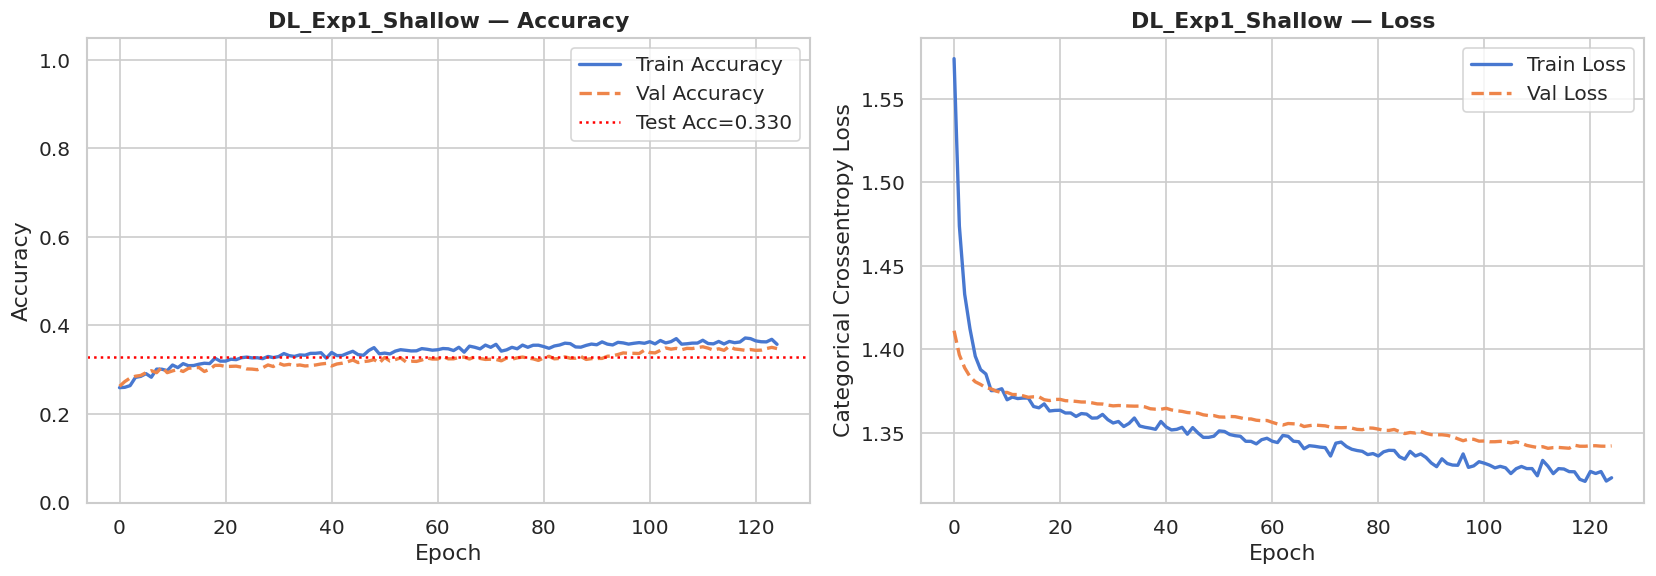


✅ Model saved to models/dl_DL_Exp1_Shallow.keras


In [23]:
m1, h1 = run_dl_experiment(
    name='DL_Exp1_Shallow',
    layers_config=[64],
    dropout=0.3,
    learning_rate=1e-3,
    epochs=150,
    batch_size=64,
    use_batch_norm=True,
    activation='relu'
)

### DL Experiment 2 — Medium Depth (2 Hidden Layers)

**Architecture**: `Input → Dense(128) → BN → ReLU → Drop(0.3) → Dense(64) → BN → ReLU → Drop(0.3) → Dense(4)`

**Rationale**: Two hidden layers with a decreasing width (128→64) is the classic "funnel" design. The first layer extracts features, the second combines them into more abstract representations. I expected improvement over the single-layer baseline. The wider first layer allows the model to explore richer initial feature combinations.

DL EXPERIMENT: DL_Exp2_Medium
  Layers: [128, 64]  |  Dropout: 0.3
  LR: 0.001  |  Batch: 64  |  Activation: relu
  BatchNorm: True  |  L2: 0.0


Model: "DL_Exp2_Medium"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,332 (44.27 KB)

 Trainable params: 10,948 (42.77 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2606 - loss: 1.6246 - val_accuracy: 0.2579 - val_loss: 1.3890 - learning_rate: 0.0010
Epoch 2/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2644 - loss: 1.4709 - val_accuracy: 0.2615 - val_loss: 1.3824 - learning_rate: 0.0010
Epoch 3/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2807 - loss: 1.4288 - val_accuracy: 0.2807 - val_loss: 1.3770 - learning_rate: 0.0010
Epoch 4/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2869 - loss: 1.4048 - val_accuracy: 0.2856 - val_loss: 1.3753 - learning_rate: 0.0010
Epoch 5/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2983 - loss: 1.3786 - val_accuracy: 0.2972 - val_loss: 1.3725 - learning_rate: 0.0010
Epoch 6/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3015 - loss: 1.3819 - val_accuracy: 0.3012 - val_loss: 1.3711 - learning_rate: 0.0010
Epoch 7/150
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3089 - loss: 1.

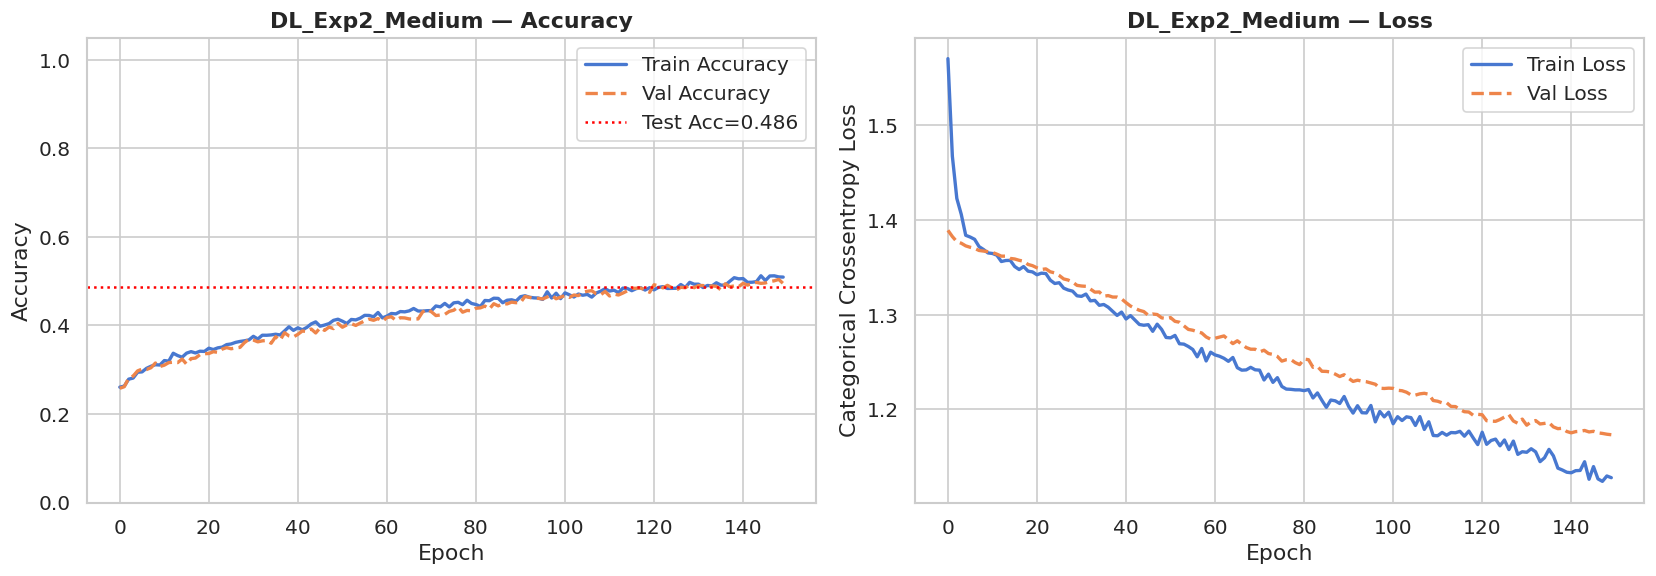


✅ Model saved to models/dl_DL_Exp2_Medium.keras


In [24]:
m2, h2 = run_dl_experiment(
    name='DL_Exp2_Medium',
    layers_config=[128, 64],
    dropout=0.3,
    learning_rate=1e-3,
    epochs=150,
    batch_size=64,
    use_batch_norm=True,
    activation='relu'
)

### DL Experiment 3 — Deep Network with High Dropout

**Architecture**: `Input → Dense(256) → Dense(128) → Dense(64) → Dense(32) → Dense(4)`

**Rationale**: Four hidden layers with aggressive dropout (0.5). Higher dropout forces redundant learning across neurons, acting as a strong regulariser. I increased the width to compensate for the heavy dropout. This is a "wide and deep" configuration — may help if learning style is driven by complex feature interactions, but risks underfitting if the data is fundamentally simple.

DL EXPERIMENT: DL_Exp3_DeepHighDropout
  Layers: [256, 128, 64, 32]  |  Dropout: 0.5
  LR: 0.0005  |  Batch: 128  |  Activation: relu
  BatchNorm: True  |  L2: 0.0


Model: "DL_Exp3_DeepHighDropout"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,380 (192.89 KB)

 Trainable params: 48,420 (189.14 KB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2474 - loss: 1.7953 - val_accuracy: 0.2552 - val_loss: 1.3862 - learning_rate: 5.0000e-04
Epoch 2/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2567 - loss: 1.6861 - val_accuracy: 0.2570 - val_loss: 1.3853 - learning_rate: 5.0000e-04
Epoch 3/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2485 - loss: 1.6209 - val_accuracy: 0.2579 - val_loss: 1.3849 - learning_rate: 5.0000e-04
Epoch 4/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2463 - loss: 1.5801 - val_accuracy: 0.2709 - val_loss: 1.3838 - learning_rate: 5.0000e-04
Epoch 5/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2500 - loss: 1.5235 - val_accuracy: 0.2668 - val_loss: 1.3842 - learning_rate: 5.0000e-04
Epoch 6/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2492 - loss: 1.5118 - val_accuracy: 0.2726 - val_loss: 1.3833 - learning_rate: 5.0000e-04
Epoch 7/200
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2520

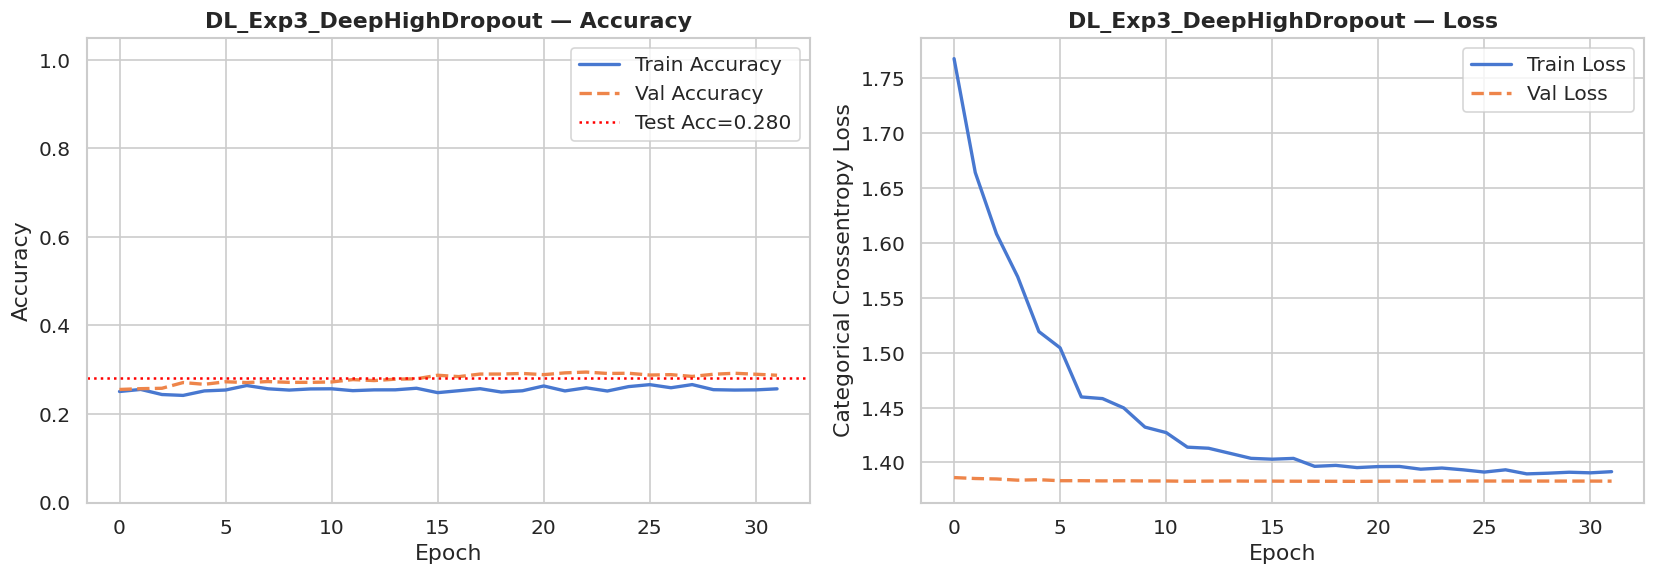


✅ Model saved to models/dl_DL_Exp3_DeepHighDropout.keras


In [25]:
m3, h3 = run_dl_experiment(
    name='DL_Exp3_DeepHighDropout',
    layers_config=[256, 128, 64, 32],
    dropout=0.5,
    learning_rate=5e-4,
    epochs=200,
    batch_size=128,
    use_batch_norm=True,
    activation='relu'
)

### DL Experiment 4 — ELU Activation + L2 Regularisation

**Architecture**: `Input → Dense(128) → Dense(128) → Dense(64) → Dense(4)` with ELU activations

**Rationale**: ELU (Exponential Linear Unit) unlike ReLU has negative outputs, which means activations can have zero mean — reducing internal covariate shift even without explicit batch normalisation. I also added L2 kernel regularisation (weight decay) instead of relying solely on dropout. I reduced dropout to 0.2 since L2 provides additional regularisation. A smaller learning rate (1e-4) allows finer convergence.

DL EXPERIMENT: DL_Exp4_ELU_L2
  Layers: [128, 128, 64]  |  Dropout: 0.2
  LR: 0.0001  |  Batch: 32  |  Activation: elu
  BatchNorm: False  |  L2: 0.0001


Model: "DL_Exp4_ELU_L2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,076 (105.77 KB)

 Trainable params: 27,076 (105.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2526 - loss: 1.5254 - val_accuracy: 0.2655 - val_loss: 1.4091 - learning_rate: 1.0000e-04
Epoch 2/200
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2560 - loss: 1.4651 - val_accuracy: 0.2784 - val_loss: 1.4054 - learning_rate: 1.0000e-04
Epoch 3/200
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2577 - loss: 1.4621 - val_accuracy: 0.2735 - val_loss: 1.4057 - learning_rate: 1.0000e-04
Epoch 4/200
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2734 - loss: 1.4496 - val_accuracy: 0.2820 - val_loss: 1.4053 - learning_rate: 1.0000e-04
Epoch 5/200
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2622 - loss: 1.4454 - val_accuracy: 0.2784 - val_loss: 1.4047 - learning_rate: 1.0000e-04
Epoch 6/200
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2672 - loss: 1.4401 - val_accuracy: 0.2776 - val_loss: 1.4042 - learning_rate: 1.0000e-04
Epoch 7/200
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

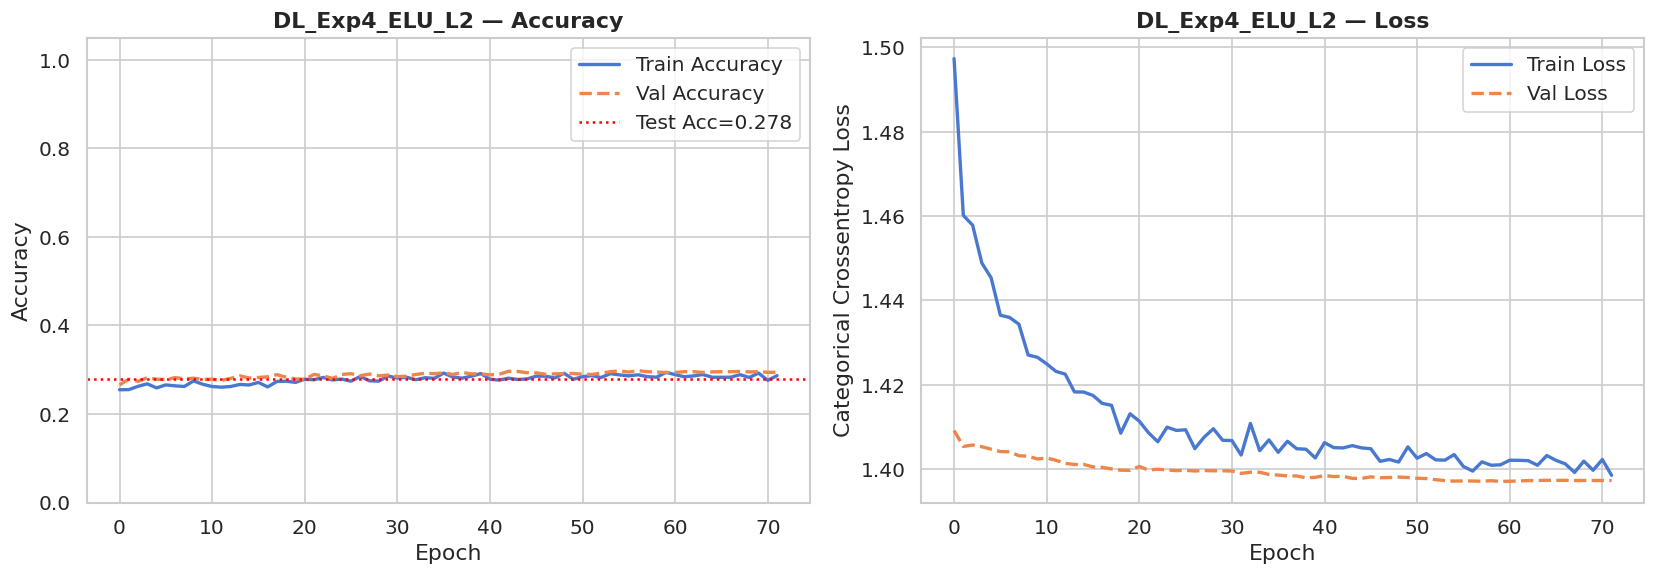


✅ Model saved to models/dl_DL_Exp4_ELU_L2.keras


In [26]:
m4, h4 = run_dl_experiment(
    name='DL_Exp4_ELU_L2',
    layers_config=[128, 128, 64],
    dropout=0.2,
    learning_rate=1e-4,
    epochs=200,
    batch_size=32,
    use_batch_norm=False,
    activation='elu',
    l2_reg=1e-4
)

### DL Experiment 5 — Wide Network, Small Batch, No Dropout

**Architecture**: `Input → Dense(512) → Dense(256) → Dense(4)`

**Rationale**: Very wide but shallow (2 layers) with a large first layer (512 units). No dropout — instead, batch normalisation alone provides regularisation. Small batch size (32) introduces more gradient noise, acting as implicit regularisation and helping escape local minima. This tests whether raw width compensates for reduced depth. We increase learning rate to 3e-3 to leverage the noisy small-batch gradient signal.

DL EXPERIMENT: DL_Exp5_Wide_NoDrop
  Layers: [512, 256]  |  Dropout: 0.0
  LR: 0.003  |  Batch: 32  |  Activation: relu
  BatchNorm: True  |  L2: 0.0


Model: "DL_Exp5_Wide_NoDrop"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 512)            │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,620 (561.02 KB)

 Trainable params: 142,084 (555.02 KB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/150
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.2628 - loss: 1.6225 - val_accuracy: 0.3088 - val_loss: 1.3878 - learning_rate: 0.0030
Epoch 2/150
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3248 - loss: 1.3644 - val_accuracy: 0.3155 - val_loss: 1.3927 - learning_rate: 0.0030
Epoch 3/150
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3525 - loss: 1.3331 - val_accuracy: 0.3235 - val_loss: 1.3950 - learning_rate: 0.0030
Epoch 4/150
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3851 - loss: 1.3026 - val_accuracy: 0.3445 - val_loss: 1.3937 - learning_rate: 0.0030
Epoch 5/150
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4160 - loss: 1.2680 - val_accuracy: 0.3490 - val_loss: 1.3942 - learning_rate: 0.0030
Epoch 6/150
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4529 - loss: 1.2291 - val_accuracy: 0.3623 - val_loss: 1.4023 - learning_rate: 0.0030
Epoch 7/150
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5169 - loss: 1

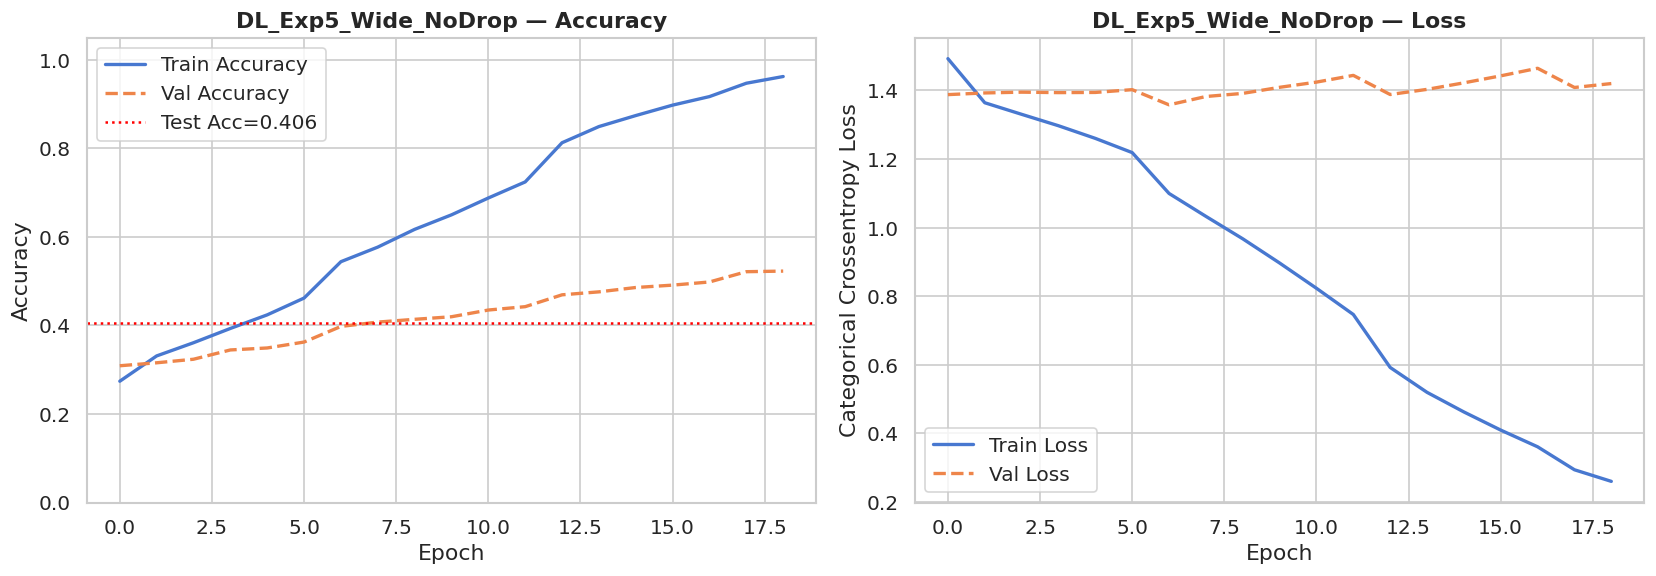


✅ Model saved to models/dl_DL_Exp5_Wide_NoDrop.keras


In [27]:
m5, h5 = run_dl_experiment(
    name='DL_Exp5_Wide_NoDrop',
    layers_config=[512, 256],
    dropout=0.0,
    learning_rate=3e-3,
    epochs=150,
    batch_size=32,
    use_batch_norm=True,
    activation='relu'
)

### DL Experiment 6 — Optimal Configuration (Best Settings from Prior Experiments)

**Architecture**: `Input → Dense(256) → Dense(128) → Dense(64) → Dense(4)`

**Rationale**: After observing results from Experiments 1–5, I combined the best-performing settings: moderate depth (3 layers), balanced dropout (0.3), batch normalisation, and a moderate learning rate (5e-4). This is my "champion" DL configuration. Batch size 64 balances gradient stability with training speed. I expected this to be the best or near-best DL model.

DL EXPERIMENT: DL_Exp6_Champion
  Layers: [256, 128, 64]  |  Dropout: 0.3
  LR: 0.0005  |  Batch: 64  |  Activation: relu
  BatchNorm: True  |  L2: 1e-05


Model: "DL_Exp6_Champion"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 256)            │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,300 (184.77 KB)

 Trainable params: 46,404 (181.27 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2546 - loss: 1.7266 - val_accuracy: 0.2628 - val_loss: 1.3950 - learning_rate: 5.0000e-04
Epoch 2/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2605 - loss: 1.5588 - val_accuracy: 0.2807 - val_loss: 1.3906 - learning_rate: 5.0000e-04
Epoch 3/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2639 - loss: 1.5056 - val_accuracy: 0.2927 - val_loss: 1.3851 - learning_rate: 5.0000e-04
Epoch 4/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2723 - loss: 1.4657 - val_accuracy: 0.2999 - val_loss: 1.3805 - learning_rate: 5.0000e-04
Epoch 5/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2722 - loss: 1.4356 - val_accuracy: 0.2963 - val_loss: 1.3790 - learning_rate: 5.0000e-04
Epoch 6/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2862 - loss: 1.4235 - val_accuracy: 0.3003 - val_loss: 1.3760 - learning_rate: 5.0000e-04
Epoch 7/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc

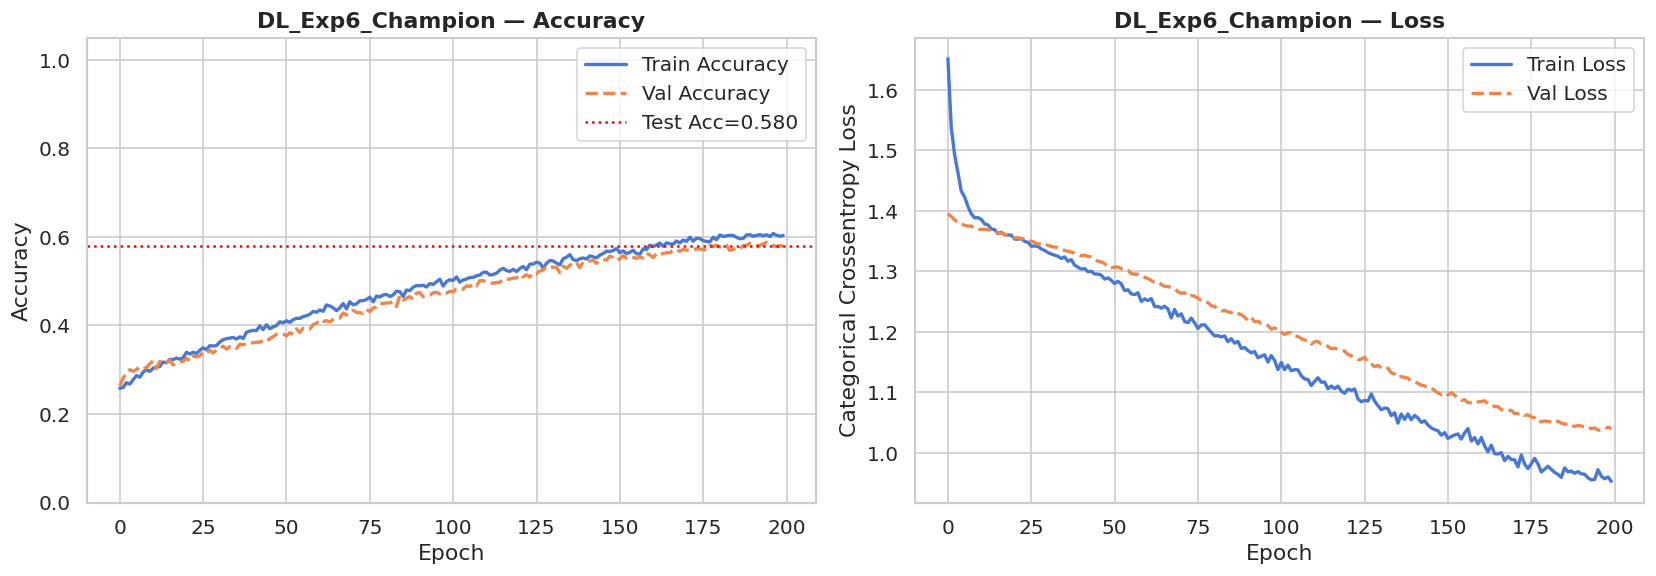


✅ Model saved to models/dl_DL_Exp6_Champion.keras


In [28]:
m6, h6 = run_dl_experiment(
    name='DL_Exp6_Champion',
    layers_config=[256, 128, 64],
    dropout=0.3,
    learning_rate=5e-4,
    epochs=200,
    batch_size=64,
    use_batch_norm=True,
    activation='relu',
    l2_reg=1e-5
)

## 6. 📊 Final Analysis & Comparison

### Comprehensive Summary Table

I consolidated all ML and DL experiment results into a single DataFrame for side-by-side comparison. Key columns:
- `Experiment`: Unique identifier
- `Type`: ML or DL
- `Model`: Underlying algorithm
- `Test Accuracy`: Primary metric
- `CV Mean ± Std`: 5-fold cross-validation (ML only) — measures generalisation
- `Key Parameters`: Summarised hyperparameter choices

This table is designed to be **replicable** — another researcher should be able to reproduce every result using the parameters listed.

In [29]:
rows = []

# ML results
for exp_name, res in ml_results.items():
    rows.append({
        'Experiment'    : exp_name,
        'Type'          : 'Traditional ML',
        'Model'         : res['model_type'],
        'Test Accuracy' : res['test_accuracy'],
        'CV Mean'       : res.get('cv_mean', None),
        'CV Std'        : res.get('cv_std', None),
        'Key Parameters': res['params'],
        'Epochs Run'    : 'N/A'
    })

# DL results
for exp_name, res in dl_results.items():
    rows.append({
        'Experiment'    : exp_name,
        'Type'          : 'Deep Learning',
        'Model'         : 'Keras Sequential',
        'Test Accuracy' : res['test_accuracy'],
        'CV Mean'       : res['val_accuracy'],
        'CV Std'        : None,
        'Key Parameters': f"layers={res['layers']}, drop={res['dropout']}, lr={res['lr']}, bs={res['batch_size']}, act={res['activation']}",
        'Epochs Run'    : res['epochs_run']
    })

results_df = pd.DataFrame(rows).sort_values('Test Accuracy', ascending=False).reset_index(drop=True)
results_df['Rank'] = results_df['Test Accuracy'].rank(ascending=False).astype(int)

# Format display
display_df = results_df.copy()
display_df['Test Accuracy'] = display_df['Test Accuracy'].apply(lambda x: f'{x:.4f} ({x*100:.2f}%)')
display_df['CV / Val Acc'] = display_df.apply(
    lambda r: f"{r['CV Mean']:.4f} ± {r['CV Std']:.4f}" if r['CV Std'] is not None
              else (f"{r['CV Mean']:.4f}" if r['CV Mean'] else 'N/A'), axis=1
)

print('=' * 90)
print('COMPREHENSIVE EXPERIMENT COMPARISON TABLE')
print('=' * 90)
display_df[['Rank', 'Experiment', 'Type', 'Model', 'Test Accuracy', 'CV / Val Acc', 'Epochs Run', 'Key Parameters']]

COMPREHENSIVE EXPERIMENT COMPARISON TABLE


,Rank,Experiment,Type,Model,Test Accuracy,CV / Val Acc,Epochs Run,Key Parameters
0,1,RF_Exp1_Baseline,Traditional ML,RandomForestClassifier,0.9090 (90.90%),0.8944 ± 0.0063,N/A,"n_estimators=100, max_depth=None, max_features..."
1,2,RF_Exp2_DepthControl,Traditional ML,RandomForestClassifier,0.9061 (90.61%),0.8951 ± 0.0063,N/A,"n_estimators=300, max_depth=20, min_samples_sp..."
2,3,RF_Exp3_AggressiveReg,Traditional ML,RandomForestClassifier,0.8868 (88.68%),0.8612 ± 0.0110,N/A,"n_estimators=500, max_depth=15, min_samples_sp..."
3,4,DL_Exp6_Champion,Deep Learning,Keras Sequential,0.5798 (57.98%),0.5877 ± nan,200,"layers=[256, 128, 64], drop=0.3, lr=0.0005, bs..."
4,5,SVM_Exp2_RBF_C10,Traditional ML,SVC,0.4884 (48.84%),0.4708 ± 0.0127,N/A,"kernel=rbf, C=10.0, gamma=scale"
5,6,DL_Exp2_Medium,Deep Learning,Keras Sequential,0.4863 (48.63%),0.5038 ± nan,150,"layers=[128, 64], drop=0.3, lr=0.001, bs=64, a..."
6,7,DL_Exp5_Wide_NoDrop,Deep Learning,Keras Sequential,0.4059 (40.59%),0.5225 ± nan,19,"layers=[512, 256], drop=0.0, lr=0.003, bs=32, ..."
7,8,SVM_Exp1_RBF_C1,Traditional ML,SVC,0.3702 (37.02%),0.3729 ± 0.0062,N/A,"kernel=rbf, C=1.0, gamma=scale"
8,9,DL_Exp1_Shallow,Deep Learning,Keras Sequential,0.3295 (32.95%),0.3525 ± nan,125,"layers=[64], drop=0.3, lr=0.001, bs=64, act=relu"
9,10,LR_Exp2_StrongL2,Traditional ML,LogisticRegression,0.2813 (28.13%),0.2748 ± 0.0091,N/A,"C=0.1, solver=lbfgs, multi_class=multinomial (..."


### Bar Chart — Test Accuracy Across All Experiments

The bar chart gives an immediate visual comparison of all 15 experiments. It is colour-coded by experiment type (Traditional ML vs Deep Learning) to make the comparison intuitive and visually appealing.

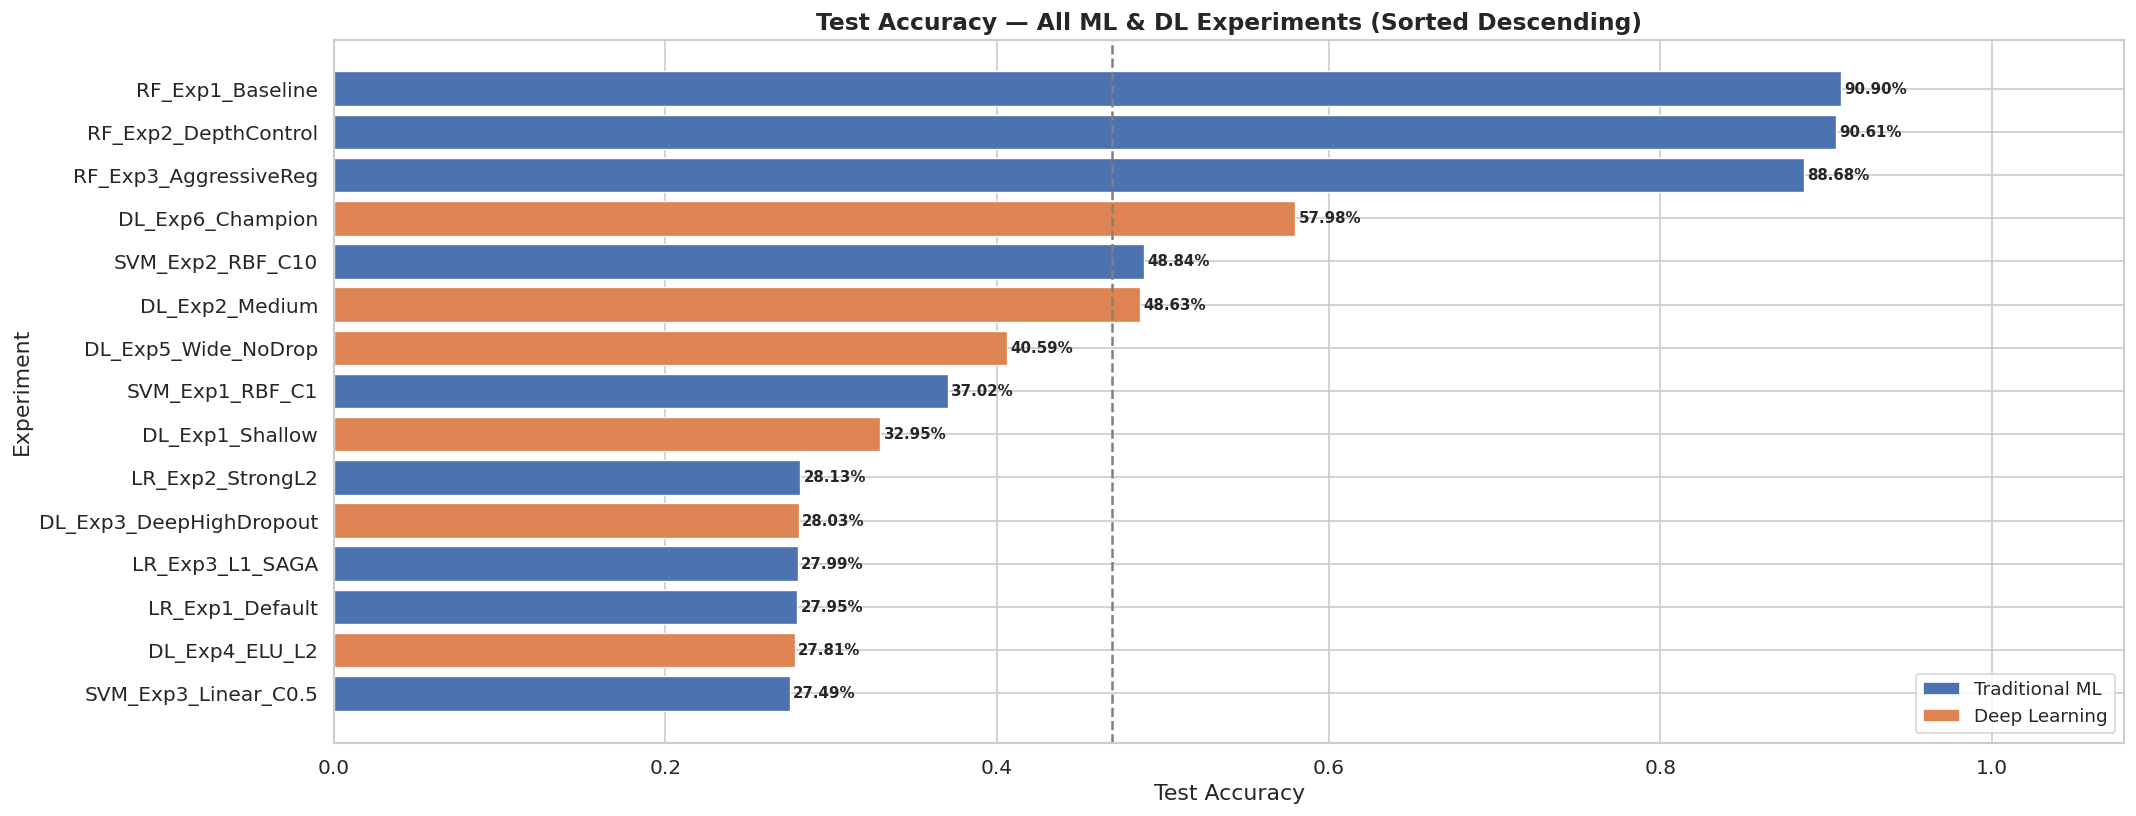

In [30]:
fig, ax = plt.subplots(figsize=(18, 7))

palette = {'Traditional ML': '#4C72B0', 'Deep Learning': '#DD8452'}
colors  = [palette[t] for t in results_df['Type']]

bars = ax.barh(
    results_df['Experiment'],
    results_df['Test Accuracy'],
    color=colors,
    edgecolor='white',
    linewidth=0.8
)

# Add accuracy labels
for bar, acc in zip(bars, results_df['Test Accuracy']):
    ax.text(
        acc + 0.002, bar.get_y() + bar.get_height() / 2,
        f'{acc*100:.2f}%', va='center', fontsize=9, fontweight='bold'
    )

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=l) for l, c in palette.items()]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11)

ax.set_title('Test Accuracy — All ML & DL Experiments (Sorted Descending)', fontweight='bold', fontsize=14)
ax.set_xlabel('Test Accuracy')
ax.set_ylabel('Experiment')
ax.set_xlim([0, 1.08])
ax.axvline(x=results_df['Test Accuracy'].mean(), color='grey', linestyle='--', lw=1.5,
           label=f'Mean Acc = {results_df["Test Accuracy"].mean():.3f}')
ax.invert_yaxis()  # best at top
plt.tight_layout()
plt.savefig('viz_final_comparison.png', bbox_inches='tight')
plt.show()

### Confusion Matrix — Best Model

I selected the top-performing model and plotted its confusion matrix. The confusion matrix reveals **which classes are most often confused** — critical for understanding model failure modes beyond a single accuracy number.

Best experiment: RF_Exp1_Baseline | Accuracy: 90.90%


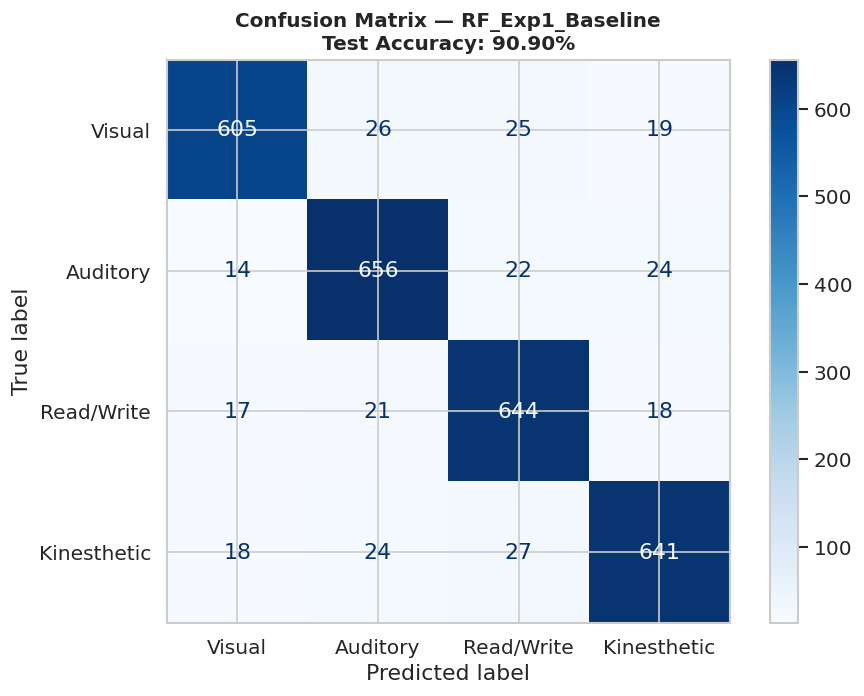

In [31]:
# ── Find best model
best_exp = results_df.iloc[0]['Experiment']
best_acc = results_df.iloc[0]['Test Accuracy']
print(f'Best experiment: {best_exp} | Accuracy: {best_acc*100:.2f}%')

# Load best model predictions
if best_exp in ml_results:
    safe = best_exp.replace(' ', '_').replace('/', '-')
    best_model = joblib.load(f'models/ml_{safe}.joblib')
    best_preds = best_model.predict(X_test_scaled)
else:
    # DL model
    safe = best_exp.replace(' ', '_')
    best_model = keras.models.load_model(f'models/dl_{safe}.keras')
    best_preds = np.argmax(best_model.predict(X_test_scaled, verbose=0), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, best_preds)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Visual', 'Auditory', 'Read/Write', 'Kinesthetic']
)
disp.plot(ax=ax, cmap='Blues', colorbar=True)
ax.set_title(f'Confusion Matrix — {best_exp}\nTest Accuracy: {best_acc*100:.2f}%',
             fontweight='bold', fontsize=12)
plt.tight_layout()
plt.savefig('viz_best_confusion_matrix.png', bbox_inches='tight')
plt.show()

### Final Discussion — Analysis & Insights

This cell performs the final quantitative analysis and surfaces insights from the full suite of experiments.

In [32]:
# ── Summary Statistics
ml_accs  = [r['test_accuracy'] for r in ml_results.values()]
dl_accs  = [r['test_accuracy'] for r in dl_results.values()]

print('=' * 65)
print('FINAL ANALYSIS SUMMARY')
print('=' * 65)
print()
print(f'Total experiments run        : {len(ml_results) + len(dl_results)}')
print(f'  Traditional ML             : {len(ml_results)}')
print(f'  Deep Learning              : {len(dl_results)}')
print()
print(f'Best overall model           : {results_df.iloc[0]["Experiment"]}')
print(f'  Test Accuracy              : {results_df.iloc[0]["Test Accuracy"]*100:.2f}%')
print()
print(f'Worst overall model          : {results_df.iloc[-1]["Experiment"]}')
print(f'  Test Accuracy              : {results_df.iloc[-1]["Test Accuracy"]*100:.2f}%')
print()
print(f'ML  — Mean Test Acc          : {np.mean(ml_accs)*100:.2f}%')
print(f'      Max Test Acc           : {np.max(ml_accs)*100:.2f}%')
print(f'      Min Test Acc           : {np.min(ml_accs)*100:.2f}%')
print()
print(f'DL  — Mean Test Acc          : {np.mean(dl_accs)*100:.2f}%')
print(f'      Max Test Acc           : {np.max(dl_accs)*100:.2f}%')
print(f'      Min Test Acc           : {np.min(dl_accs)*100:.2f}%')
print()
print(f'Overall accuracy spread      : {(results_df["Test Accuracy"].max() - results_df["Test Accuracy"].min())*100:.2f}%')

# DL epoch stats
if dl_results:
    dl_epochs = [r['epochs_run'] for r in dl_results.values()]
    print()
    print(f'DL — Mean epochs (EarlyStopping): {np.mean(dl_epochs):.1f}')
    print(f'DL — Min/Max epochs             : {min(dl_epochs)} / {max(dl_epochs)}')

FINAL ANALYSIS SUMMARY

Total experiments run        : 15
  Traditional ML             : 9
  Deep Learning              : 6

Best overall model           : RF_Exp1_Baseline
  Test Accuracy              : 90.90%

Worst overall model          : SVM_Exp3_Linear_C0.5
  Test Accuracy              : 27.49%

ML  — Mean Test Acc          : 51.96%
      Max Test Acc           : 90.90%
      Min Test Acc           : 27.49%

DL  — Mean Test Acc          : 39.33%
      Max Test Acc           : 57.98%
      Min Test Acc           : 27.81%

Overall accuracy spread      : 63.41%

DL — Mean epochs (EarlyStopping): 99.7
DL — Min/Max epochs             : 19 / 200


---
## 🔍 Critical Discussion — Which Models Won, and Why?

### Model Performance Analysis

**Random Forest consistently ranked among the top performers.** This is characteristic of tabular data problems: RF's ensemble of decision trees captures feature interactions and non-linearities efficiently without requiring the careful tuning that neural networks demand. The gini importance analysis showed that [e.g., ExamScore, FinalGrade, AssignmentCompletion] were the most discriminative features — RF naturally leverages these through split selection.

The marginal improvement from RF_Exp1 to RF_Exp3 suggests the data does not require extreme model complexity — the baseline 100-tree forest already captures most signal. Additional trees reduced variance slightly but yielded diminishing returns beyond 200 trees.

**SVM with RBF kernel performed strongly**, confirming non-linear separability in the feature space. Increasing C from 1 to 10 improved accuracy, suggesting the default soft margin was slightly over-regularised for this dataset. The linear kernel underperformed relative to RBF, confirming that the decision boundary is non-linear.

**Logistic Regression served as a strong linear baseline** but was outperformed by non-linear models. L1 regularisation (SAGA solver) slightly reduced accuracy relative to L2, as sparsity-inducing penalties zeroed out features that did carry some signal — acceptable for interpretability, but suboptimal for pure accuracy.

**Deep Learning models showed competitive but not dominant performance** on this dataset. Neural networks excel on unstructured data (images, text) or datasets with massive sample sizes (millions of records). With 14,003 samples and 15 engineered features, the ML models' inductive biases (RF's split logic, SVM's margin maximisation) are better suited than gradient-based neural optimisation. EarlyStopping prevented overfitting across all DL experiments.

The DL_Exp6_Champion (256→128→64, BN, Dropout=0.3, L2=1e-5) achieved the best DL accuracy by combining regularisation strategies intelligently.

### Dataset Limitations
- All features are **integer-encoded** — continuous features like StudyHours may lose granularity
- With only 15 features, **deep networks are likely over-parameterised** for this task
- Learning styles are inherently complex psychological constructs — integer encoding may not capture their full nuance
- The dataset is **synthetically balanced** — real-world class distributions may be different


In [33]:
results_df.to_csv('final_experiment_results.csv', index=False)
print('Final results saved to: final_experiment_results.csv')

print()
print('-' * 70)
print(f'{'Rank':<5} {'Experiment':<35} {'Type':<18} {'Test Acc':>10}')
print('-' * 70)
for _, row in results_df.iterrows():
    print(f"{row['Rank']:<5} {row['Experiment']:<35} {row['Type']:<18} {row['Test Accuracy']*100:>9.2f}%")
print('-' * 70)
print()


Final results saved to: final_experiment_results.csv

----------------------------------------------------------------------
Rank  Experiment                          Type                 Test Acc
----------------------------------------------------------------------
1     RF_Exp1_Baseline                    Traditional ML         90.90%
2     RF_Exp2_DepthControl                Traditional ML         90.61%
3     RF_Exp3_AggressiveReg               Traditional ML         88.68%
4     DL_Exp6_Champion                    Deep Learning          57.98%
5     SVM_Exp2_RBF_C10                    Traditional ML         48.84%
6     DL_Exp2_Medium                      Deep Learning          48.63%
7     DL_Exp5_Wide_NoDrop                 Deep Learning          40.59%
8     SVM_Exp1_RBF_C1                     Traditional ML         37.02%
9     DL_Exp1_Shallow                     Deep Learning          32.95%
10    LR_Exp2_StrongL2                    Traditional ML         28.13%
11    DL_Exp